#### Import Libraries

In [1]:
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm
import datetime
# import nc_time_axis
# from cftime import DatetimeNoLeap
import numpy as np
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
import glob
from braceexpand import braceexpand
import os
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'
# This code make the next section of code to stop acting silly
dask.config.set({"array.slicing.split_large_chunks": True})
	# True: smaller chunks are used
	# False: large chunks are accepted

In [2]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.

def assign_LT_coord(da):
	hour_offset = (da.lon.values/15).round(decimals=0)
	hour_offset = hour_offset.repeat(len(da.time)).reshape((len(da.lon),len(da.time))).T
	local_time = np.empty([len(da.time),len(da.lon)], dtype=object)
	for i in range(local_time.shape[0]):
		for j in range(local_time.shape[1]):
			local_time[i,j] = da.time.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
	da = da.assign_coords(LocalTime=(('time','lon'),local_time))
	return da

In [3]:
def hov_diurnal(da):
    # Average over the bounds to create shape of (time,west_east)
    da_avg = da.where((da.lat>lat_avg_bound[0])&(da.lat<lat_avg_bound[1]),drop=True).mean(dim='lat')
    # Create a np.array with shape (west_east,hour). Then populate each longitude column with its respective
        # diurnal cycle of rain rate.
    array = np.zeros((da_avg.shape[1],24))
    # Loop through each longitude, look through all the timesteps and group them by hour,
        # and then average the values at each hour. Output the 1x24 array into the empty array
    for i in range(array.shape[0]):
        array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()
    return array

In [4]:
# Set the bounds you want to look at
lat_bound = [-5,5]		# South to North
lon_bound_d01 = [80,135]	# West to East
lon_bound_d02 = [90,125]	# West to East
lat_avg_bound = [-5,5]

## __Assigning File Path Names__

#### Spatio-Temporal Climotological > the year 2000

In [5]:
# # ERA-5 Rain Rate data (1950-2019)
# 	# Precipitation is in m/day
# x = list(braceexpand('/data/deluge/reanalysis/REANALYSIS/ERA5/2D/4xdaily/precip/*{11,12}.nc'))
# filepath_RR = []
# for i in range(0,len(x)):
# 	filepath_RR.extend(glob.glob(x[i]))

# ERA-5 Zonal wind data (1950-2019)
	# Zonal wind is in m/s
x = list(braceexpand('/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.2*.nc'))
filepath_U = []
for i in range(0,len(x)):
	filepath_U.extend(glob.glob(x[i]))

# Reading in IMERG data (mid-2000-2019)
	# Precipitation is in mm/hr
x = list(braceexpand('/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.2*.nc'))
filepath_IMERG = []
for i in range(0,len(x)):
	filepath_IMERG.extend(glob.glob(x[i]))


## Just 2015 Nov-Dec

In [5]:
# Reading in IMERG data (Nov-Dec 2015)
	# Precipitation is in mm/hr

# x = list(braceexpand('/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.2015*{11,12}.nc'))
# filepath_IMERG = []
# for i in range(0,len(x)):
# 	filepath_IMERG.extend(glob.glob(x[i]))

filepath_IMERG = '/new_data/nsakaeda/GPM/IMERG/imerg.v6b.2015.nc4'

filepath_Mask_IMERG = '/data/hnajarian/IMERG_land_sea_mask.nc'

# Reading in CMORPH data (Nov-Dec 2015)
	# Precipitation is in mm/hr
x = list(braceexpand('/new_data/nsakaeda/CMORPH/30min/cmorph_8km-30min.2015*{11,12}.nc'))
filepath_CMORPH = []
for i in range(0,len(x)):
	filepath_CMORPH.extend(glob.glob(x[i]))


# Reading in NOAA/PSD Interpolated OLR 1 Times Daily
	# OLR is in W/m^2
filepath_NOAA_OLR = '/data/nsakaeda/OLR/olr.1x.7918.nc'

# Reading in ERA-5 Zonal wind (Nov-Dec 2015)
x = list(braceexpand('/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.2015*{11,12}.nc'))
filepath_U = []
for i in range(0,len(x)):
	filepath_U.extend(glob.glob(x[i]))

#### Spatio-Temporal Nov-Jan of 2015 and 2017

In [ ]:
# ERA-5 Zonal wind data (1950-2019)
	# Zonal wind is in m/s
x = list(braceexpand('/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.20{15,17}*{11,12}.nc'))
y = list(braceexpand('/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.20{16,18}*01.nc'))
filepath_U = []
for i in range(0,len(x)):
	filepath_U.extend(glob.glob(x[i]))
for i in range(0,len(y)):
	filepath_U.extend(glob.glob(y[i]))

# Reading in IMERG data (mid-2000-2019)
	# Precipitation is in mm/hr
x = list(braceexpand('/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.20{15,17}*{11,12}.nc'))
y = list(braceexpand('/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.20{16,18}*01.nc'))
filepath_IMERG = []
for i in range(0,len(x)):
	filepath_IMERG.extend(glob.glob(x[i]))
for i in range(0,len(y)):
	filepath_IMERG.extend(glob.glob(y[i]))

#### Spatio-Temporal of Hand Selected MJO + Neutral ENSO events

In [ ]:
# These are years and months of hand picked MJO events that occurred 
# between phases 3-5 (RMM), and during Nuetral ENSO events (NINO3.4)
# that had a decent MJO convective signal 
## Sources:
# RMM:				http://www.bom.gov.au/climate/mjo/ 
# NINO3.4: 			https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php 
# Convective signal:https://www.atmos.albany.edu/facstaff/roundy/waves/hovsdet/7.5S_7.5N/

filepath_IMERG = []
filepath_IMERG.extend(['/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.200312.nc'])
filepath_IMERG.extend(['/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.200612.nc'])
filepath_IMERG.extend(['/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.200701.nc'])
for i in range(0,5):
	filepath_IMERG.extend(glob.glob(list(braceexpand('/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.2004*{01,02,03,04,05}.nc'))[i]))
for i in range(0,2):
	filepath_IMERG.extend(glob.glob(list(braceexpand('/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.2005*{03,04}.nc'))[i]))
for i in range(0,2):
	filepath_IMERG.extend(glob.glob(list(braceexpand('/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.2014*{11,12}.nc'))[i]))
for i in range(0,2):
	filepath_IMERG.extend(glob.glob(list(braceexpand('/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.2018*{05,06}.nc'))[i]))
for i in range(0,2):
	filepath_IMERG.extend(glob.glob(list(braceexpand('/new_data/nsakaeda/GPM/IMERG/imerg_3hrly/imerg.v6b.precipitationCal.8x.2019*{04,05}.nc'))[i]))


filepath_U = []
filepath_U.extend(['/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.200312.nc'])
filepath_U.extend(['/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.200612.nc'])
filepath_U.extend(['/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.200701.nc'])
for i in range(0,5):
	filepath_U.extend(glob.glob(list(braceexpand('/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.2004*{01,02,03,04,05}.nc'))[i]))
for i in range(0,2):
	filepath_U.extend(glob.glob(list(braceexpand('/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.2005*{03,04}.nc'))[i]))
for i in range(0,2):
	filepath_U.extend(glob.glob(list(braceexpand('/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.2014*{11,12}.nc'))[i]))
for i in range(0,2):
	filepath_U.extend(glob.glob(list(braceexpand('/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.2018*{05,06}.nc'))[i]))
for i in range(0,2):
	filepath_U.extend(glob.glob(list(braceexpand('/data/deluge/reanalysis/REANALYSIS/ERA5/3D/4xdaily/uwnd/uwnd.2019*{04,05}.nc'))[i]))

#### TRMM Filtered data 2015-2018

In [ ]:
# Reading in TRMM 3b42 v7a filtered for the MJO (1998-2019)
	# MJO band (zonal wavenumber 0 to 8, periods 30 to 96 days, equivalent depth -999 to -999 m)"
	# 8x daily
filepath_TRMM_MJO = '/data/nsakaeda/TRMM/filtered_data/trmm.3b42.v7a.precipitation.fillmiss.2.5deg.1998-2019.50S50N.MJO.nc'



#### Index File Pathnames

In [ ]:
# MJO (Madden Jullian-Oscillation)
filepath_RMM = '/data/nsakaeda/ClimateIndices/rmm.74toRealtime.txt'
# filepath_OMI = 

# ENSO (https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php)
filepath_ERSSTv5_NINO34 = '/data/nsakaeda/ClimateIndices/ersst5.nino.mth.81-10.ascii.txt'
# filepath_MEI = 

# IOD
# filepath_IDO = 

# QBO
# filepath_QBO = 

## Reading in the files

In [ ]:
# Climate Indicies

# RMM Index
df_RMM = pd.read_table(filepath_RMM,delim_whitespace=True,header=1)
df_RMM = df_RMM.drop(columns=['Missing','Value=','1.E36','or','999'])
df_RMM = df_RMM.rename(columns={'year,':'Year','month,':'Month','day,':'Day','RMM1,':'RMM1'
                            ,'RMM2,':'RMM2','phase,':'Phase','amplitude.':'Amplitude'})

# Create a method of finding the indicies that have phases moving from 3-5, and jot the year&month down

# temp = df_RMM[(df_RMM['Amplitude'] > 1) & ((df_RMM['Phase'] >= 3) & (df_RMM['Phase'] <= 5)) & (df_RMM['Year']>=2000)]
# temp
# days = 35   # 90 days/8 phases
# for i in temp-days
#     if temp['Phase'].iloc[i] != 3:
#         continue
#     x = temp[i:i+days]


# ENSO Index (NINO 3.4)
df_NINO34 = pd.read_table(filepath_ERSSTv5_NINO34,delim_whitespace=True,header=0)
df_NINO34 = df_NINO34.drop(columns=['NINO1+2','ANOM','NINO3','ANOM.1','NINO4','ANOM.2','NINO3.4'])
df_NINO34 = df_NINO34.rename(columns={'ANOM.3':'ANOM34'})

In [ ]:
# Climatological December Average Rainfall Rates using ERA-5

# # Using ERA5 rain rate data (sus) (1979-2019)
# ds_RR_all = xr.open_mfdataset(filepath_RR, combine='by_coords')	# chunks=can tell it how many chunks you wanna make! Look up documentation
# with ProgressBar():
# 	RR_Dec_all = ds_RR_all['precip'].sel(
# 		longitude=slice(60,300),
# 		latitude=slice(30,-30),
# 		time=slice('1979','2019')
# 	).mean('time').compute()	# Compute will force it to compute the full selection to assign the var to the data!
# RR_Dec_all = RR_Dec_all*1000 	# Convert to mm/day
# print('This is the size of the ERA5-precip dataset in (lat,lon): ', RR_Dec_all.shape)


In [6]:
# Set the bounds you want to look at
lat_bound = [-5,5]		# South to North
lon_bound = [80,135]	# West to East

# # Just had to run this once
# ds_RR_IMERG = xr.open_dataset(filepath_IMERG)
# da_RR_IMERG = ds_RR_IMERG['precipitationCal'].sel(
# 	lon=slice(lon_bound[0],lon_bound[1]),
# 	lat=slice(lat_bound[0],lat_bound[1]),
#   	time=slice('2015-11-22 12:00','2015-12-03 00:00')
# )
# da_RR_IMERG.to_netcdf('/data/hnajarian/imerg_2015-11-22-12:00-12-03-00:00.nc')

## IMERG rainfall rates just for Nov 22 - Dec 3
ds_RR_IMERG = xr.open_dataset('/data/hnajarian/imerg_2015-11-22-12:00-12-03-00:00.nc')
# Change coordinates from +-180° to 0-360°
ds_RR_IMERG = ds_RR_IMERG.assign_coords(lon=(ds_RR_IMERG.lon % 360)).sortby('lon')
da_RR_IMERG = ds_RR_IMERG['precipitationCal'].compute()
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = da_RR_IMERG.indexes['time'].to_datetimeindex()
da_RR_IMERG = da_RR_IMERG.assign_coords(time=datetimeindex)
da_RR_IMERG = da_RR_IMERG.transpose('time','lat','lon')
da_RR_IMERG = assign_LT_coord(da_RR_IMERG)
print('This is the size of the IMERG data array in (time,lat,lon): ', da_RR_IMERG.shape)

# IMERG Land-Sea Mask
# The file displays percent water surface coverage with 100% = all water and 0% = all land.
# Land sea is also called land ocean or land water. 
# Typical percentage thresholds used to define sea are 100% (strictly open water) 
	# or 75% (including sea-ward coast areas). 
# Typical percentages used to define strictly land are 25% or 15%; 
	# too low a percentage masks out humid regions that have many lakes and reservoirs.

ds_Mask_IMERG = xr.open_dataset(filepath_Mask_IMERG)
# Change coordinates from +-180° to 0-360°
ds_Mask_IMERG = ds_Mask_IMERG.assign_coords(lon=(ds_Mask_IMERG.lon % 360)).sortby('lon')
da_Mask_IMERG = ds_Mask_IMERG['landseamask'].sel(
    lon=slice(lon_bound[0],lon_bound[1]),
	lat=slice(lat_bound[0],lat_bound[1])
).compute()
# Repeat it so that a time dimension is added
x = da_Mask_IMERG.values.repeat(len(da_RR_IMERG.time)).reshape((len(da_Mask_IMERG.lat),
                                                            len(da_Mask_IMERG.lon),
                                                            len(da_RR_IMERG.time)))
x = np.transpose(x, (2,0,1))
da_Mask_IMERG = xr.DataArray(
    data = x,
    dims = ['time','lat','lon'],
    coords = dict(
        lat=('lat',da_RR_IMERG.lat.values),
        lon=('lon',da_RR_IMERG.lon.values),
        time=('time',da_RR_IMERG.time.values)
        ))

/tmp/ipykernel_5938/2052667571.py:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = da_RR_IMERG.indexes['time'].to_datetimeindex()


This is the size of the IMERG data array in (time,lat,lon):  (505, 100, 550)


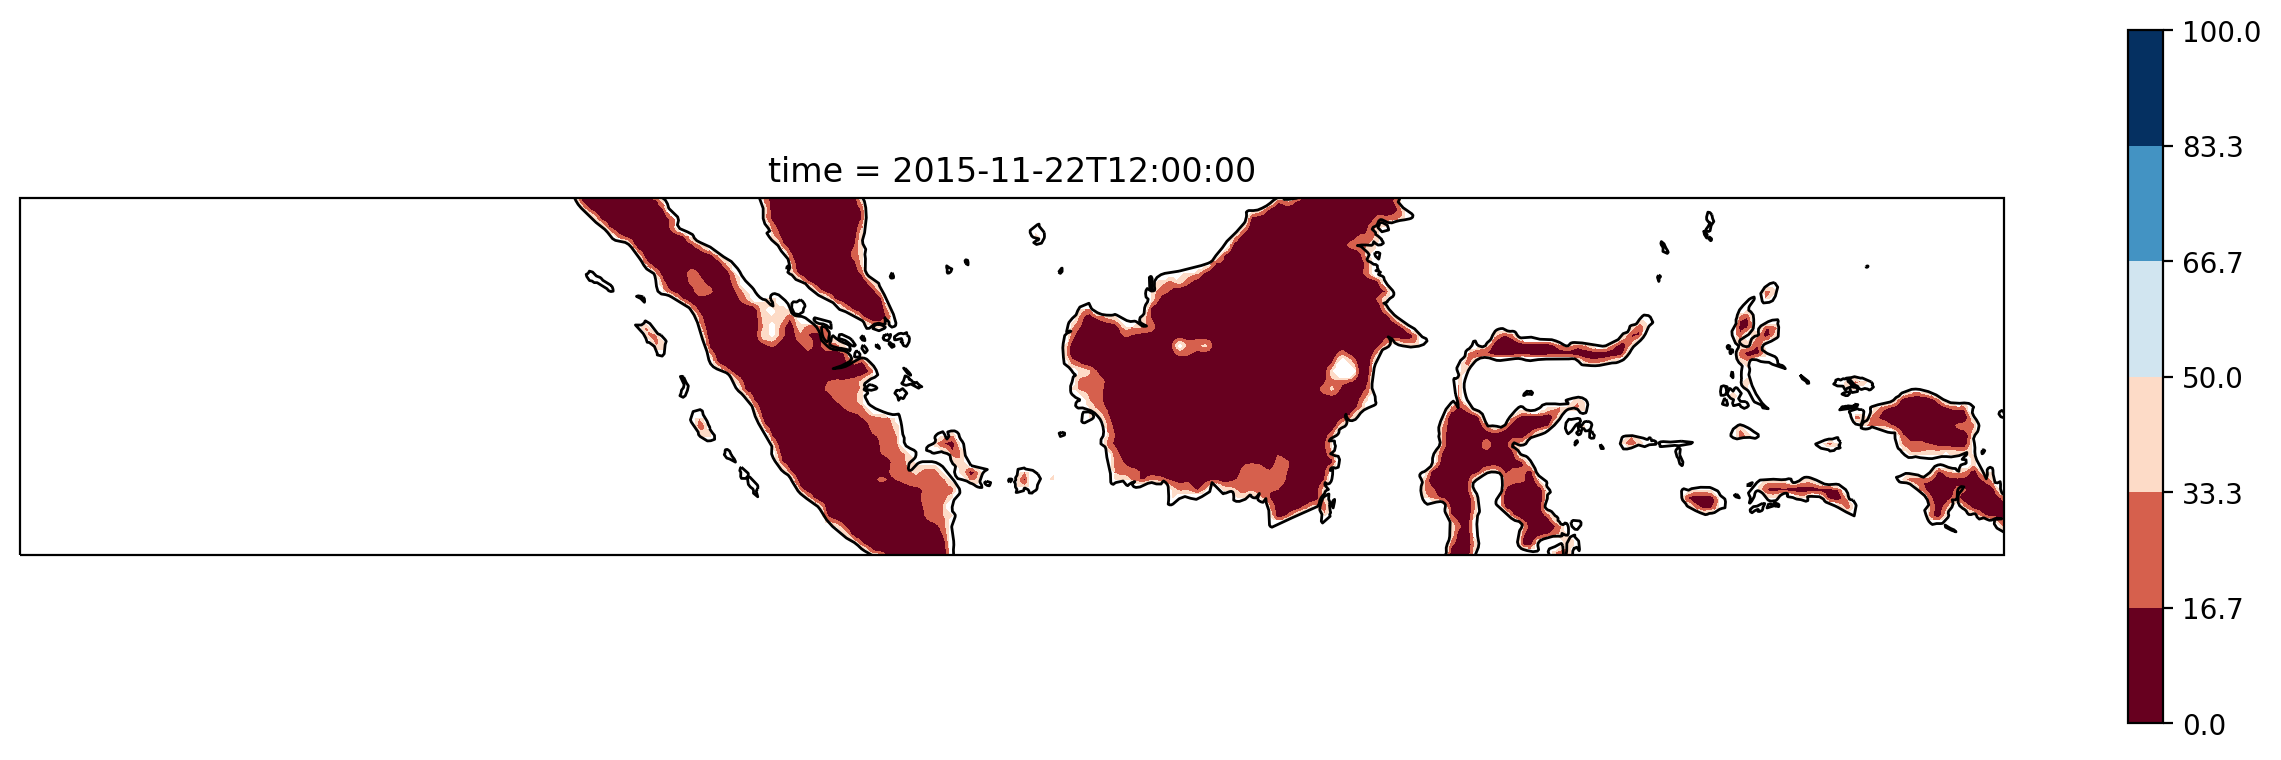

In [8]:
# Testing IMERG MASK
fig = plt.figure(figsize=(16,4.5))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
cf1 = da_Mask_IMERG[0,...].where(da_Mask_IMERG[0,...]<50).plot.contourf(
	cmap='RdBu',		# _r reverses the colorbar order!
    vmin=0,vmax=100
)
ax1.coastlines(linewidth=1, color='k', resolution='50m')  # cartopy function


In [ ]:
# # Just had to run this once
# ds_RR_CMORPH = xr.open_mfdataset(filepath_CMORPH, combine='by_coords')
# da_RR_CMORPH = ds_RR_CMORPH['cmorph'].sel(
# 	lon=slice(lon_bound[0],lon_bound[1]),
# 	lat=slice(lat_bound[0],lat_bound[1]),
#   time=slice('2015-11-22-12:00','2015-12-03-00:00')
# )
# da_RR_CMORPH.to_netcdf('/data/hnajarian/cmorph_2015-11-22-12:00-12-03-00:00.nc')

ds_RR_CMORPH = xr.open_dataset('/data/hnajarian/cmorph_2015-11-22-12:00-12-03-00:00.nc')
da_RR_CMORPH = ds_RR_CMORPH['cmorph'].compute()

print('This is the size of the CMORPH data array in (time,lat,lon): ', da_RR_CMORPH.shape)

ds_OLR = xr.open_dataset(filepath_NOAA_OLR)
da_OLR = ds_OLR['olr'].sel(
    lon=slice(lon_bound[0],lon_bound[1]),
	lat=slice(lat_bound[0],lat_bound[1]),
  	time=slice('2015-11-22','2015-12-03')
).compute()

print('This is the size of the OLR data array in (time,lat,lon): ', da_OLR.shape)

In [7]:
# Using ERA-5 850-hPa zonal wind data
# This is dataset (ds)
ds_U = xr.open_mfdataset(filepath_U, combine='by_coords')
# This is a dataarray
da_U850 = ds_U['uwnd'].sel(
	longitude=slice(lon_bound[0],lon_bound[1]),
	latitude=slice(lat_bound[1],lat_bound[0]),
	time=slice('2015-11-22','2015-12-03'),
	level=850
).compute()

# Using ERA-5 200-hPa zonal wind data
# This is dataset (ds)
ds_U = xr.open_mfdataset(filepath_U, combine='by_coords')
# This is a dataarray
da_U200 = ds_U['uwnd'].sel(
	longitude=slice(lon_bound[0],lon_bound[1]),
	latitude=slice(lat_bound[1],lat_bound[0]),
	time=slice('2015-11-22','2015-12-03'),
	level=200
).compute()


In [ ]:
# Climatological December Average Rainfall Rates (~10-11 min/month)

# Using IMERG rain rate data (2000-2019)
ds_RR_all = xr.open_mfdataset(filepath_IMERG, combine='by_coords')
# Change coordinates from +-180° to 0-360°
ds_RR_all = ds_RR_all.assign_coords(lon=(ds_RR_all.lon % 360)).sortby('lon')

with ProgressBar():
	RR_Dec_all = ds_RR_all['precipitationCal'].sel(
		lon=slice(lon_bound[0],lon_bound[1]),
		lat=slice(lat_bound[0],lat_bound[1])
	).compute()
	
print('This is the size of the IMERG dataset in (time,lat,lon): ', RR_Dec_all.shape)

In [ ]:
# Climatological December Average Zonal Winds (~13-14 min/month)

# Using ERA-5 850 hPa zonal wind data
# This is dataset (ds)
ds_U_all = xr.open_mfdataset(filepath_U, combine='by_coords')
with ProgressBar():
	# This is a dataarray
	U850_Dec_all = ds_U_all['uwnd'].sel(
		longitude=slice(lon_bound[0],lon_bound[1]),
		latitude=slice(lat_bound[1],lat_bound[0]),
		# time=slice('1979','2019'),
		level=850
	).compute()

print('This is the size of the ERA5-uwnd dataset in (lat,lon): ', U850_Dec_all.shape)

In [ ]:
# Filtered MJO data

# Using TRMM filtered rain rate data
ds_RR_MJO = xr.open_dataset(filepath_TRMM_MJO)

with ProgressBar():
	RR_MJO_all = ds_RR_MJO['precipitation'].sel(
		lon=slice(lon_bound[0],lon_bound[1]),
		lat=slice(lat_bound[0],lat_bound[1])
	).compute()

#### Extract 2015 and 2017 data

In [ ]:
# December 2015 values
U850_Dec_2015 = U850_Dec_all.sel(time=slice('2015-11','2016-01'))
RR_Dec_2015 = RR_Dec_all.sel(time=slice('2015-11','2016-01'))
RR_MJO_2015 = RR_MJO_all.sel(time=slice('2015-11','2016-01'))

# December 2017 values
U850_Dec_2017 = U850_Dec_all.sel(time=slice('2017-11','2018-01'))
RR_Dec_2017 = RR_Dec_all.sel(time=slice('2017-11','2018-01'))
RR_MJO_2017 = RR_MJO_all.sel(time=slice('2017-11','2018-01'))

In [ ]:
# December 2015 anomalous values
U850_Dec_2015_ano = U850_Dec_2015.groupby('time.hour') - U850_Dec_all.groupby('time.hour').mean('time')
RR_Dec_2015_ano = RR_Dec_2015.groupby('time.hour') - RR_Dec_all.groupby('time.hour').mean('time')
# December 2017 anomalous values
U850_Dec_2017_ano = U850_Dec_2017.groupby('time.hour') - U850_Dec_all.groupby('time.hour').mean('time')
RR_Dec_2017_ano = RR_Dec_2017.groupby('time.hour') - RR_Dec_all.groupby('time.hour').mean('time')

## __Plotting__

#### _Evolution of ENSO and RMM index_

In [ ]:
# fig, ax1 = plt.subplots(
# 	1, 1, figsize=(10,4.5),
# 	)

# ax2 = ax1.twinx()
# ax1.plot(df_NINO34.ANOM34,color='b')
# ax1.axhline(y=0.5,color='b',linestyle='--')
# ax1.axhline(y=-0.5,color='b',linestyle='--')
# # plt.plot(df_NINO34.ANOM34,color='b')
# # plt.axhline(y=0.5,color='b',linestyle='--')
# # plt.axhline(y=-0.5,color='b',linestyle='--')

# # Make it look pretty
# ax1.set_xticks(df_NINO34.index[0::60])
# x_tick_labels = [df_NINO34.YR[0::60]]
# # # x_tick_labels = list(map(list, zip(*x_tick_labels)))
# ax1.set_xticklabels(list(map(list, zip(*x_tick_labels))))
# plt.ylim(-3,3)
# plt.xlim(df_NINO34.index[0],df_NINO34.index[-1])
# ax1.set_xlabel('')
# ax1.set_ylabel('NINO3.4 Anoamly', color='b')


#### _Climatological December Daily Rainfall Rate_

In [ ]:
fig, ax = plt.subplots(
	1, 1, figsize=(15,3),
	subplot_kw=dict(projection=ccrs.Mercator(
		central_longitude=180
		)
	)
)
# Add coast lines
ax.coastlines(linewidth=0.5)  # cartopy function
# Set your longitude and latitude extents
ax.set_extent([60,300,-30,30], crs=ccrs.PlateCarree())

# Plot the data
RR_Dec_all.plot.pcolormesh(
	ax=ax,
	transform=ccrs.PlateCarree(),  # this is important!
	cmap='Blues',
	vmin=0, vmax=1,
	extend = 'both',
	cbar_kwargs={'label': 'Precipitation [mm/hr]'}	# 'ticks': np.arange(0,.07,.01)
)

# Making it look pretty
plt.title('Climatological December Daily Average Rainfall')


gl = ax.gridlines(
	draw_labels=True, linewidth=0.5, color='k', linestyle='-', alpha=0.5
	)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

fig, ax = plt.subplots(
	1, 1, figsize=(15,3), subplot_kw=dict(projection=ccrs.Mercator(
central_longitude=180,
min_latitude=-30,
max_latitude=30))
)

RR_Dec_2015_ano.plot.pcolormesh(
		transform=ccrs.PlateCarree(),  # this is important!
		cmap='RdBu',
		vmin=-1, vmax=1,
		extend = 'both',
		cbar_kwargs={'label': 'Precipitation [mm/hr]'}	# 'ticks': np.arange(0,.07,.01)
)
# Add coast lines
ax.coastlines(linewidth=0.5)  # cartopy function

# Making it look pretty
# plt.title('Anamlous December 2015 Daily Average Rainfall')
plt.title('December 2015 Daily Anomalous Rainfall')

gl = ax.gridlines(
	draw_labels=True, linewidth=1, color='k', linestyle='-', alpha=0.5
	)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

fig, ax = plt.subplots(
	1, 1, figsize=(15,3), subplot_kw=dict(projection=ccrs.Mercator(
central_longitude=180,
min_latitude=-30,
max_latitude=30))
)

RR_Dec_2017_ano.plot.pcolormesh(
		transform=ccrs.PlateCarree(),  # this is important!
		cmap='RdBu',
		vmin=-1, vmax=1,
		extend = 'both',
		cbar_kwargs={'label': 'Precipitation [mm/hr]'}	# 'ticks': np.arange(0,.07,.01)
)
# Add coast lines
ax.coastlines(linewidth=0.5)  # cartopy function

# Making it look pretty
plt.title('December 2017 Daily Anomalous Rainfall')

gl = ax.gridlines(
	draw_labels=True, linewidth=1, color='k', linestyle='-', alpha=0.5
	)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

fig, ax = plt.subplots(
	1, 1, figsize=(15,3), subplot_kw=dict(projection=ccrs.Mercator(
central_longitude=180,
min_latitude=-30,
max_latitude=30))
)

RR_Dec_Diff = RR_Dec_2015_ano - RR_Dec_2017_ano
RR_Dec_Diff.plot.pcolormesh(
		transform=ccrs.PlateCarree(),  # this is important!
		cmap='RdBu',
		vmin=-1, vmax=1,
		extend = 'both',
		cbar_kwargs={'label': 'Precipitation [mm/hr]'}	# 'ticks': np.arange(0,.07,.01)
)

# RR_Dec_Diff.plot.contourf(
# 	ax=ax,
# 	transform=ccrs.PlateCarree(),  # this is important!
# 	add_colorbar=True,
# 	vmin=-12, vmax=9,
# 	cmap='RdBu',
# 	center=0,
# 	extend='both',
# 	cbar_kwargs={'label': 'Precipitation [mm/day]'}
# )


# Add coast lines
ax.coastlines(linewidth=0.5)  # cartopy function

# Making it look pretty
plt.title('Difference b/w December 2015 & 2017 Daily Average Rainfall')

gl = ax.gridlines(
	draw_labels=True, linewidth=1, color='k', linestyle='-', alpha=0.5
	)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)


#### _Climatological December Zonal Winds_

In [ ]:
fig, ax = plt.subplots(
	1, 1, figsize=(15,3), subplot_kw=dict(projection=ccrs.Mercator(
central_longitude=180,
min_latitude=-30,
max_latitude=30))
)

# # countour filled
# U850_Dec_all.plot.pcolormesh(
# 	transform=ccrs.PlateCarree(),  # this is important!
# 	cmap='RdBu',
# 	vmin=-12, vmax=9,
# 	extend = 'both',
# 	cbar_kwargs={'label': 'Zonal Winds [m/s]'}	# 'ticks': np.arange(0,.07,.01)
# )

# # Another method to contour filled?
# U850_Dec_2015_ano.plot.contourf(
# 	ax=ax,
# 	transform=ccrs.PlateCarree(),  # this is important!
# 	add_colorbar=True,
# 	vmin=-12, vmax=9,
# 	cmap='RdBu',
# 	center=0,
# 	extend='both',
# 	cbar_kwargs={'label': 'Precipitation [mm/day]'}
# )

# contours
CS = U850_Dec_all.plot.contour(
	transform=ccrs.PlateCarree(),  # this is important!
	colors='k',
	levels=np.arange(-12,9,3),
)
ax.clabel(CS, inline=True)

# Add coast lines
ax.coastlines(linewidth=0.5)  # cartopy function

# Making it look pretty
plt.title('Climatological December Average Zonal Winds')

gl = ax.gridlines(
	draw_labels=True, linewidth=1, color='k', linestyle='-', alpha=0.5
	)
gl.top_labels = False
gl.right_labels = False

# Y-label
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
# X-label
ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

fig, ax = plt.subplots(
	1, 1, figsize=(15,3), subplot_kw=dict(projection=ccrs.Mercator(
central_longitude=180,
min_latitude=-30,
max_latitude=30))
)
CS = U850_Dec_2015_ano.plot.contour(
		transform=ccrs.PlateCarree(),  # this is important!
		colors='k',
		levels=np.arange(-6,8,2)
)
ax.clabel(CS, inline=True)
# Add coast lines
ax.coastlines(linewidth=0.5)  # cartopy function

# Making it look pretty
# plt.title('Anamlous December 2015 Daily Average Rainfall')
plt.title('December 2015 Anomalous Zonal Winds')

gl = ax.gridlines(
	draw_labels=True, linewidth=1, color='k', linestyle='-', alpha=0.5
	)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

fig, ax = plt.subplots(
	1, 1, figsize=(15,3), subplot_kw=dict(projection=ccrs.Mercator(
central_longitude=180,
min_latitude=-30,
max_latitude=30))
)
CS = U850_Dec_2017_ano.plot.contour(
		transform=ccrs.PlateCarree(),  # this is important!
		colors='k',
		levels=np.arange(-6,8,2)
)
ax.clabel(CS, inline=True)
# Add coast lines
ax.coastlines(linewidth=0.5)  # cartopy function

# Making it look pretty
# plt.title('Anamlous December 2015 Daily Average Rainfall')
plt.title('December 2017 Anomalous Zonal Winds')

gl = ax.gridlines(
	draw_labels=True, linewidth=1, color='k', linestyle='-', alpha=0.5
	)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

fig, ax = plt.subplots(
	1, 1, figsize=(15,3), subplot_kw=dict(projection=ccrs.Mercator(
central_longitude=180,
min_latitude=-30,
max_latitude=30))
)

U850_Dec_Diff = U850_Dec_2015 - U850_Dec_2017

CS = U850_Dec_Diff.plot.contour(
		transform=ccrs.PlateCarree(),  # this is important!
		colors='k',
		levels=np.arange(-9,9,3)
)
ax.clabel(CS, inline=True)
# Add coast lines
ax.coastlines(linewidth=0.5)  # cartopy function

# Making it look pretty
# plt.title('Anamlous December 2015 Daily Average Rainfall')
plt.title('Difference b/w December 2015 & 2017 Daily Average 850hPa Zonal Winds')

gl = ax.gridlines(
	draw_labels=True, linewidth=1, color='k', linestyle='-', alpha=0.5
	)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)


In [ ]:
fig, ax = plt.subplots(
	1, 1, figsize=(15,3), subplot_kw=dict(projection=ccrs.Mercator(
central_longitude=180,
min_latitude=-30,
max_latitude=30))
)

# December rainfall differences
RR_Dec_Diff = RR_Dec_2015_ano - RR_Dec_2017_ano
RR_Dec_Diff.plot.pcolormesh(
		transform=ccrs.PlateCarree(),  # this is important!
		cmap='RdBu',
		vmin=-1, vmax=1,
		extend = 'both',
		cbar_kwargs={'label': 'Precipitation [mm/hr]'}	# 'ticks': np.arange(0,.07,.01)
)

# December zonal wind differences
U850_Dec_Diff = U850_Dec_2015 - U850_Dec_2017
CS = U850_Dec_Diff.plot.contour(
		transform=ccrs.PlateCarree(),  # this is important!
		colors='0.3',
		levels=np.arange(-9,9,3)
)
ax.clabel(CS, inline=True)

# Add coast lines
ax.coastlines(linewidth=1, color='k')  # cartopy function

# Making it look pretty
plt.title('Difference b/w December 2015 & 2017 Rain Rate and Zonal Winds')

gl = ax.gridlines(
	draw_labels=True, linewidth=1, color='k', linestyle='-', alpha=0.5
	)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)


#### _Hovmoller Diagram of Zonal winds & Rain rate_

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2015 = [np.datetime64('2015-11-23T00:00'), np.datetime64('2015-12-16T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_2015.sel(
	lat=slice(-5,5), 
	time=slice('2015-11-16','2016-01-15')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_2015.sel(
	latitude=slice(5,-5),
	time=slice('2015-11-16','2016-01-15')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2015[0],times_2015[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2015[1],times_2015[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov-Jan 15/16', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2017 = [np.datetime64('2017-12-05T00:00'), np.datetime64('2018-01-15T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_2017.sel(
	lat=slice(-5,5), 
	time=slice('2017-11-16','2018-01-15')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_2017.sel(
	latitude=slice(5,-5),
	time=slice('2017-11-16','2018-01-15')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2017[0],times_2017[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2017[1],times_2017[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov-Jan 17/18', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2017 = [np.datetime64('2003-12-05T00:00'), np.datetime64('2018-01-15T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_2017.sel(
	lat=slice(-5,5), 
	time=slice('2017-11-16','2018-01-15')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_2017.sel(
	latitude=slice(5,-5),
	time=slice('2017-11-16','2018-01-15')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2017[0],times_2017[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2017[1],times_2017[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov-Jan 17/18', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2003 = [np.datetime64('2003-12-06T00:00'), np.datetime64('2003-12-23T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_all.sel(
	lat=slice(-5,5), 
	time=slice('2003-12-01','2003-12-31')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_all.sel(
	latitude=slice(5,-5),
	time=slice('2003-12-01','2003-12-31')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2003[0],times_2003[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2003[1],times_2003[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Dec 2003', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2004 = [np.datetime64('2004-01-27T00:00'), np.datetime64('2004-02-08T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_all.sel(
	lat=slice(-5,5), 
	time=slice('2004-01-17','2004-02-18')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_all.sel(
	latitude=slice(5,-5),
	time=slice('2004-01-17','2004-02-18')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2004[0],times_2004[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2004[1],times_2004[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Jan-Feb 2004', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2004 = [np.datetime64('2004-03-01T00:00'), np.datetime64('2004-03-20T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_all.sel(
	lat=slice(-5,5), 
	time=slice('2004-02-23','2004-03-25')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_all.sel(
	latitude=slice(5,-5),
	time=slice('2004-02-23','2004-03-25')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2004[0],times_2004[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2004[1],times_2004[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Mar 2004', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2004 = [np.datetime64('2004-04-27T00:00'), np.datetime64('2004-05-14T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_all.sel(
	lat=slice(-5,5), 
	time=slice('2004-04-21','2004-05-20')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_all.sel(
	latitude=slice(5,-5),
	time=slice('2004-04-21','2004-05-20')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2004[0],times_2004[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2004[1],times_2004[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Apr-May 2004', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2005 = [np.datetime64('2005-03-20T00:00'), np.datetime64('2005-04-13T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_all.sel(
	lat=slice(-5,5), 
	time=slice('2005-03-16','2005-04-17')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_all.sel(
	latitude=slice(5,-5),
	time=slice('2005-03-16','2005-04-17')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2005[0],times_2005[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2005[1],times_2005[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Mar-Apr 2005', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2006 = [np.datetime64('2006-12-20T00:00'), np.datetime64('2007-01-08T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_all.sel(
	lat=slice(-5,5), 
	time=slice('2006-12-14','2007-01-14')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_all.sel(
	latitude=slice(5,-5),
	time=slice('2006-12-14','2007-01-14')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2006[0],times_2006[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2006[1],times_2006[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Dec-Jan 06/07', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2014 = [np.datetime64('2014-11-20T00:00'), np.datetime64('2014-12-05T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_all.sel(
	lat=slice(-5,5), 
	time=slice('2014-11-12','2014-12-13')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_all.sel(
	latitude=slice(5,-5),
	time=slice('2014-11-12','2014-12-13')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2014[0],times_2014[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2014[1],times_2014[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov-Dec 2014', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2018 = [np.datetime64('2018-05-27T00:00'), np.datetime64('2018-06-07T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_all.sel(
	lat=slice(-5,5), 
	time=slice('2018-05-17','2018-06-17')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_all.sel(
	latitude=slice(5,-5),
	time=slice('2018-05-17','2018-06-17')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2018[0],times_2018[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2018[1],times_2018[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: May-June 2018', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,13))

times_2019 = [np.datetime64('2019-04-24T00:00'), np.datetime64('2019-05-04T00:00')]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.2,.01,0.76,0.015,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1]+15,15))
x_tick_labels = [u'75\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E',
                 u'165\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = RR_Dec_all.sel(
	lat=slice(-5,5), 
	time=slice('2019-04-14','2019-05-14')
).mean('lat')*24	# Make it rain rate per day instead of hour
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = x.indexes['time'].to_datetimeindex()
x = x.assign_coords(time=datetimeindex)
y = U850_Dec_all.sel(
	latitude=slice(5,-5),
	time=slice('2019-04-14','2019-05-14')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-10, vmax=10,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1]+15,15),
	cmap='gray',
	levels=np.arange(10,80,5),
	vmin=10, vmax=70,
	extend='max'
)
# Plot the times where YMC occurred
plt.plot([x.lon[0],x.lon[-1]],[times_2019[0],times_2019[0]],
	linestyle='--',
	linewidth=2,
	color='r')
plt.plot([x.lon[0],x.lon[-1]],[times_2019[1],times_2019[1]],
	linestyle='--',
	linewidth=2,
	color='r')

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Apr-May 2019', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(y.time[0::20])
# ax2.set_yticklabels()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


# CMORPH + IMERG + OLR analysis

In [21]:
# Set the bounds you want to look at
lat_bound = [-5,5]		# South to North
lon_bound_d01 = [80,135]	# West to East
lon_bound_d02 = [90,125]	# West to East

CMORPH d01

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('CMORPH Rain rate', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_RR_CMORPH.where(
    (da_RR_CMORPH.lat>lat_avg_bound[0]) & (da_RR_CMORPH.lat<lat_avg_bound[1]),
    drop=True).mean('lat')*24

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray_r',
	levels=np.arange(0,75,5),
	vmin=0, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('CMORPH Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.time[0::12*2].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.time[0::12*2])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

IMERG d01

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG Rain rate', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_RR_IMERG.where(
    (da_RR_IMERG.lat>lat_avg_bound[0]) & (da_RR_IMERG.lat<lat_avg_bound[1]),
    drop=True).mean('lat')*24


ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray_r',
	levels=np.arange(0,75,5),
	vmin=0, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('IMERG Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.time[0::12*2].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.time[0::12*2])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

CMORPH d02

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,12))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])

x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('CMORPH Rain rate', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_RR_CMORPH.where(
    (da_RR_CMORPH.lat>lat_avg_bound[0]) & (da_RR_CMORPH.lat<lat_avg_bound[1]),
    drop=True).mean('lat')*24

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray_r',
	levels=np.arange(0,75,5),
	vmin=0, vmax=70,
	extend='max',
    xlim=[lon_bound_d02[0], lon_bound_d02[1]]
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('CMORPH Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.time[0::12*2].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.time[0::12*2])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


IMERG d02

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,12))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])

x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG Rain rate', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_RR_IMERG.where(
    (da_RR_IMERG.lat>lat_avg_bound[0]) & (da_RR_IMERG.lat<lat_avg_bound[1]),
    drop=True).mean('lat')*24


ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray_r',
	levels=np.arange(0,75,5),
	vmin=0, vmax=70,
	extend='max',
    xlim=[lon_bound_d02[0], lon_bound_d02[1]]
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('IMERG Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.time[0::12*2].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.time[0::12*2])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


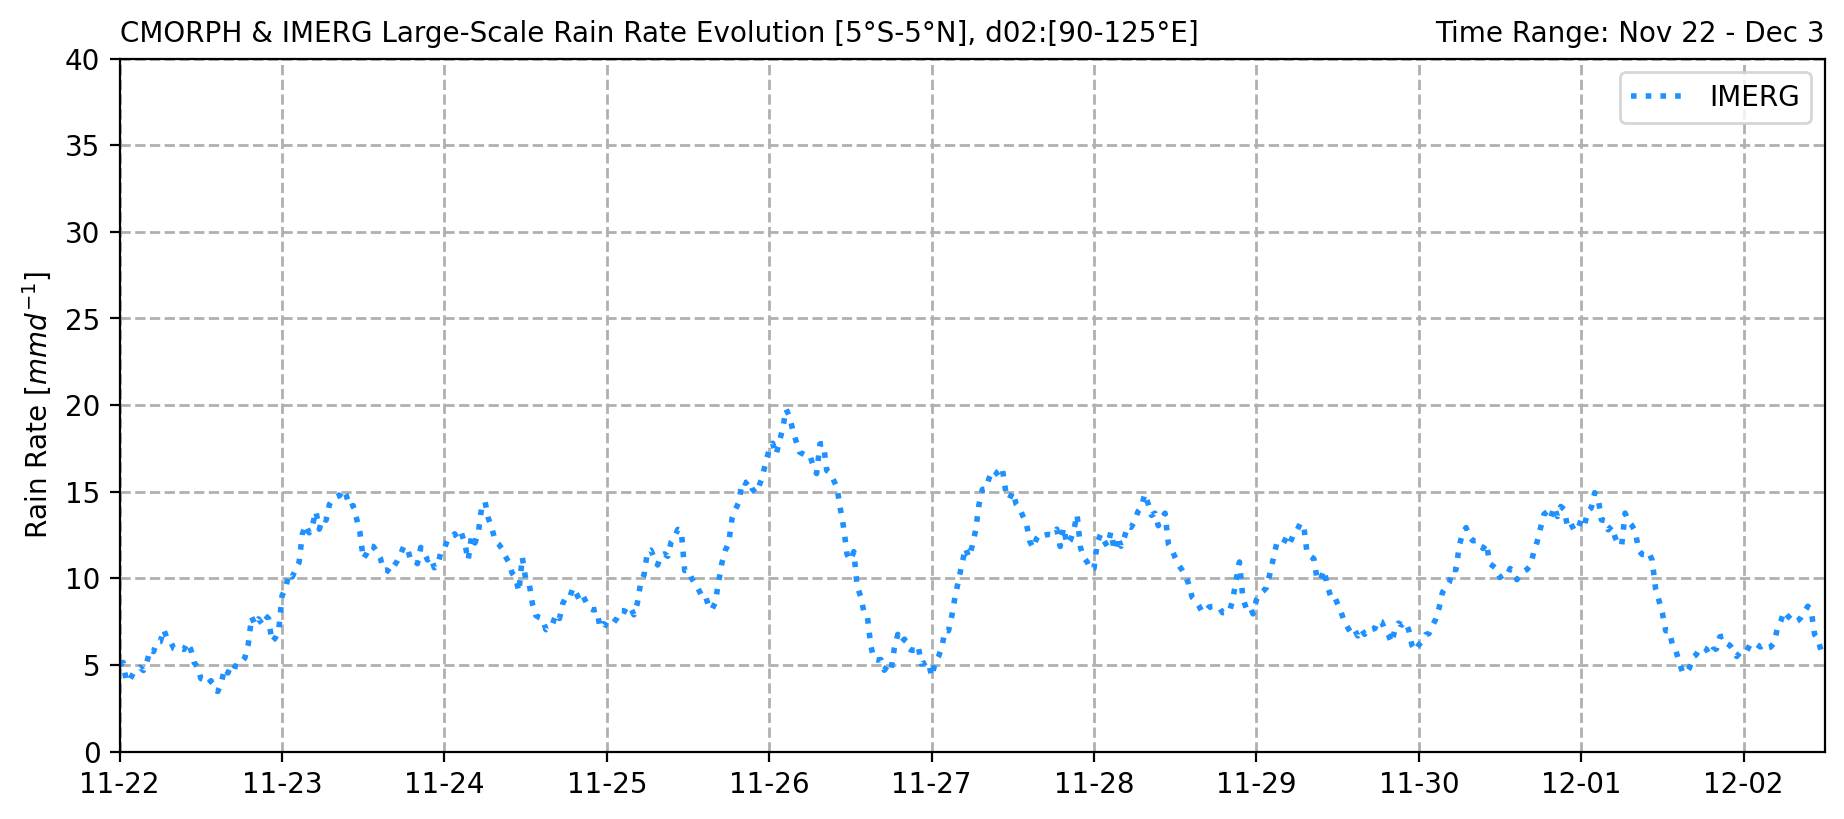

In [16]:
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

# # Calculate the average rainfall over lat + lon and plot the time evolution
# # d01
# x1 = da_RR_CMORPH.where(
#     (da_RR_CMORPH.lat>lat_avg_bound[0]) & (da_RR_CMORPH.lat<lat_avg_bound[1]) 
#     & (da_RR_CMORPH.lon>lon_bound_d01[0]) & (da_RR_CMORPH.lon<lon_bound_d01[1]),
#     drop=False).mean('lat').mean('lon')*24
# # d02
# x2 = da_RR_CMORPH.where(
#     (da_RR_CMORPH.lat>lat_avg_bound[0]) & (da_RR_CMORPH.lat<lat_avg_bound[1]) 
#     & (da_RR_CMORPH.lon>lon_bound_d02[0]) & (da_RR_CMORPH.lon<lon_bound_d02[1]),
#     drop=False).mean('lat').mean('lon')*24

x3 = da_RR_IMERG.where(
    (da_RR_IMERG.lat>lat_avg_bound[0]) & (da_RR_IMERG.lat<lat_avg_bound[1]) 
    & (da_RR_IMERG.lon>lon_bound_d01[0]) & (da_RR_IMERG.lon<lon_bound_d01[1]),
    drop=False).mean('lat').mean('lon')*24

x4 = da_RR_IMERG.where(
    (da_RR_IMERG.lat>lat_avg_bound[0]) & (da_RR_IMERG.lat<lat_avg_bound[1]) 
    & (da_RR_IMERG.lon>lon_bound_d02[0]) & (da_RR_IMERG.lon<lon_bound_d02[1]),
    drop=False).mean('lat').mean('lon')*24

# a = x1.plot.line(
#     ax=ax1,
#     xlim=[x1.time[0],x1.time[72]],
#     ylim=[0,40],
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
#     label='CMORPH-d01'
# )
# b = x2.plot.line(
#     xlim=[x1.time[0],x1.time[72]],
#     ylim=[0,40],
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
#     label='CMORPH'
# )
# c = x3.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = ':',
#     label='IMERG-d01'
# )
d = x4.plot.line(
    xlim=[x4.time[0],x4.time[-1]],
    ylim=[0,40],
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = ':',
    label='IMERG'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('CMORPH & IMERG Large-Scale Rain Rate Evolution [5°S-5°N], d02:[90-125°E]', loc='left', fontsize=10)
# ax1.set_title('Time Range: Nov-22--28', loc='right', fontsize=10)
ax1.set_title('Time Range: Nov 22 - Dec 3', loc='right', fontsize=10)
ax1.set_title('')
ax1.tick_params(rotation=0)
# ax1.set_xticks(x1.time[24::48])
# ax1.set_xticklabels(np.array(x1.time[24::48].dt.strftime("%Y-%m-%d")))
ax1.set_xticks(x3.time[0::48])
ax1.set_xticklabels(np.array(x3.time[0::48].dt.strftime("%m-%d")),horizontalalignment='center')

ax1.set_xlabel('')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(loc='upper right')


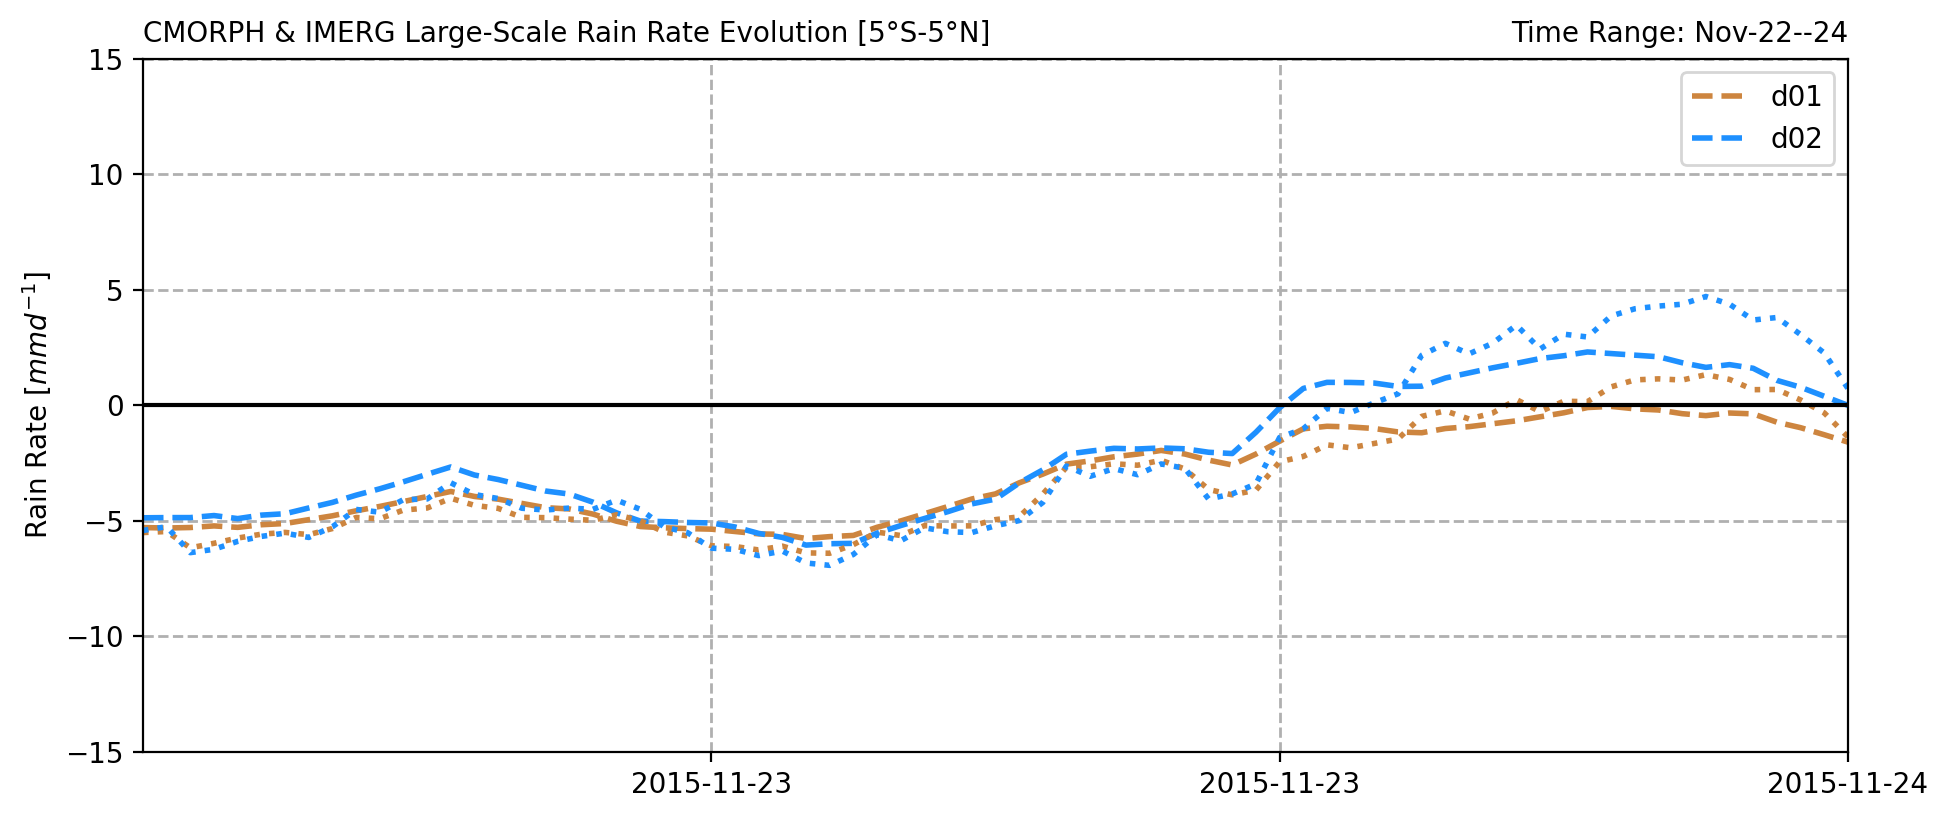

In [28]:
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

# Calculate the average rainfall over lat + lon and plot the time evolution
# d01
x1 = da_RR_CMORPH.where(
    (da_RR_CMORPH.lat>lat_avg_bound[0]) & (da_RR_CMORPH.lat<lat_avg_bound[1]) 
    & (da_RR_CMORPH.lon>lon_bound_d01[0]) & (da_RR_CMORPH.lon<lon_bound_d01[1]),
    drop=True).mean('lat').mean('lon')*24
x1 = x1 - x1.mean('time')
# d02
x2 = da_RR_CMORPH.where(
    (da_RR_CMORPH.lat>lat_avg_bound[0]) & (da_RR_CMORPH.lat<lat_avg_bound[1]) 
    & (da_RR_CMORPH.lon>lon_bound_d02[0]) & (da_RR_CMORPH.lon<lon_bound_d02[1]),
    drop=True).mean('lat').mean('lon')*24
x2 = x2 - x2.mean('time')

# d01
x3 = da_RR_IMERG.where(
    (da_RR_IMERG.lat>lat_avg_bound[0]) & (da_RR_IMERG.lat<lat_avg_bound[1]) 
    & (da_RR_IMERG.lon>lon_bound_d01[0]) & (da_RR_IMERG.lon<lon_bound_d01[1]),
    drop=True).mean('lat').mean('lon')*24
x3 = x3 - x3.mean('time')
# d02
x4 = da_RR_IMERG.where(
    (da_RR_IMERG.lat>lat_avg_bound[0]) & (da_RR_IMERG.lat<lat_avg_bound[1]) 
    & (da_RR_IMERG.lon>lon_bound_d02[0]) & (da_RR_IMERG.lon<lon_bound_d02[1]),
    drop=True).mean('lat').mean('lon')*24
x4 = x4 - x4.mean('time')

a = x1.plot.line(
    ax=ax1,
    xlim=[x1.time[0],x1.time[-1]],
    color='peru',
    linewidth=2,
    linestyle = '--'
)
b = x2.plot.line(
    ax=ax1,
    # xlim=[0,23],
    ylim=[-15,15],
    color='dodgerblue',
    linewidth=2,
    linestyle = '--'
)
c = x3.plot.line(
    ax=ax1,
    xlim=[x1.time[0],x1.time[-1]],
    color='peru',
    linewidth=2,
    linestyle = ':'
)
d = x4.plot.line(
    ax=ax1,
    # xlim=[0,23],
    ylim=[-15,15],
    color='dodgerblue',
    linewidth=2,
    linestyle = ':'
)
plt.axhline(y = 0, color = 'k', linestyle = '-')

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('CMORPH & IMERG Large-Scale Rain Rate Evolution [5°S-5°N]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov-22--28', loc='right', fontsize=10)
ax1.set_title('')
ax1.tick_params(rotation=0)
ax1.set_xticks(x1.time[24::48])
ax1.set_xticklabels(np.array(x1.time[24::48].dt.strftime("%Y-%m-%d")))
ax1.set_xlabel('')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(['d01','d02'], loc='upper right')


Spatial analysis of RR_hourly

In [ ]:
fig = plt.figure(figsize=(9,16))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
height_ratio = np.full(12,0.9)
height_ratio = np.append(height_ratio,0.15)
gs = gridspec.GridSpec(nrows=13, ncols=2, hspace=0.05, wspace=0, height_ratios=height_ratio)
levels = [0,65]
dl = 5
# Data
x = da_RR_CMORPH.sel(
    time=slice('2015-11-24 00:00','2015-11-25 00:00',2)
)
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N']

for i in range(2):
	for j in range(12):
		ax = fig.add_subplot(gs[j, i], projection=ccrs.PlateCarree(central_longitude=0))
		ax.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
		# Plot the coast lines
		ax.coastlines(linewidth=0.5, color='w', resolution='50m')  # cartopy function
		cf = x[(i*12)+j,:,:].plot.contourf(
			ax=ax,
			add_colorbar=False,
			cmap='jet',
			levels=np.arange(levels[0],levels[1],dl),
			vmin=0, vmax=levels[1]-dl,
			extend='max',
			xlim=[lon_bound_d02[0], lon_bound_d02[1]]
		)
		ax.set_title('')
		ax.set_xlabel('')
		ax.set_ylabel('')
		ax.set_xticks([])
		# ax.set_yticks([-2.5,0,2.5])
		# ax.set_yticklabels(y_tick_labels)
		if j == 11:
			ax.set_xlabel('Longitude')
			ax.set_xticks([90,100,110,120])
			ax.set_xticklabels(x_tick_labels)
		if i == 1:
			ax.set_yticks([])

ax = fig.add_subplot(gs[-1, :])
cbar = plt.colorbar(cf, cax=ax, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')

# # Create grids
# ax2.grid(linestyle='--', axis='x', linewidth=1.5)
# ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# # Plot the colorbars
# 	# Rain rate colorbar
# ax4 = fig.add_subplot(gs[4, :])
# cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
# cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# # Set titles/labels
# ax2.set_title('IMERG Rain rate', loc='left', fontsize=10)
# ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
# ax2.set_title('', loc='center')

# ax2.set_xticklabels(x_tick_labels)
# t = x1.time[0::12*2].dt.strftime("%b-%d, %H:%M")
# ax2.set_yticks(x1.time[0::12*2])
# ax2.set_yticklabels(t.values)
# ax2.set_xlabel('Longitude')
# ax2.set_ylabel('')


In [ ]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
# Data
x = da_RR_CMORPH.sel(
    time=slice('2015-11-24 00:00','2015-11-25 00:00',2)
)*24
# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='w', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [0,85]
dl = 5

cf = x[0,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')

for i in range(24):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 
    ax1.set_title('CMORPH rain rate evolution',loc='left')
    ax1.set_title(np.datetime_as_string(x.time[i],unit='m'))
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # plt.savefig('plots/CMORPH'+np.datetime_as_string(x.time[i],unit='m')+'.png',dpi=300)


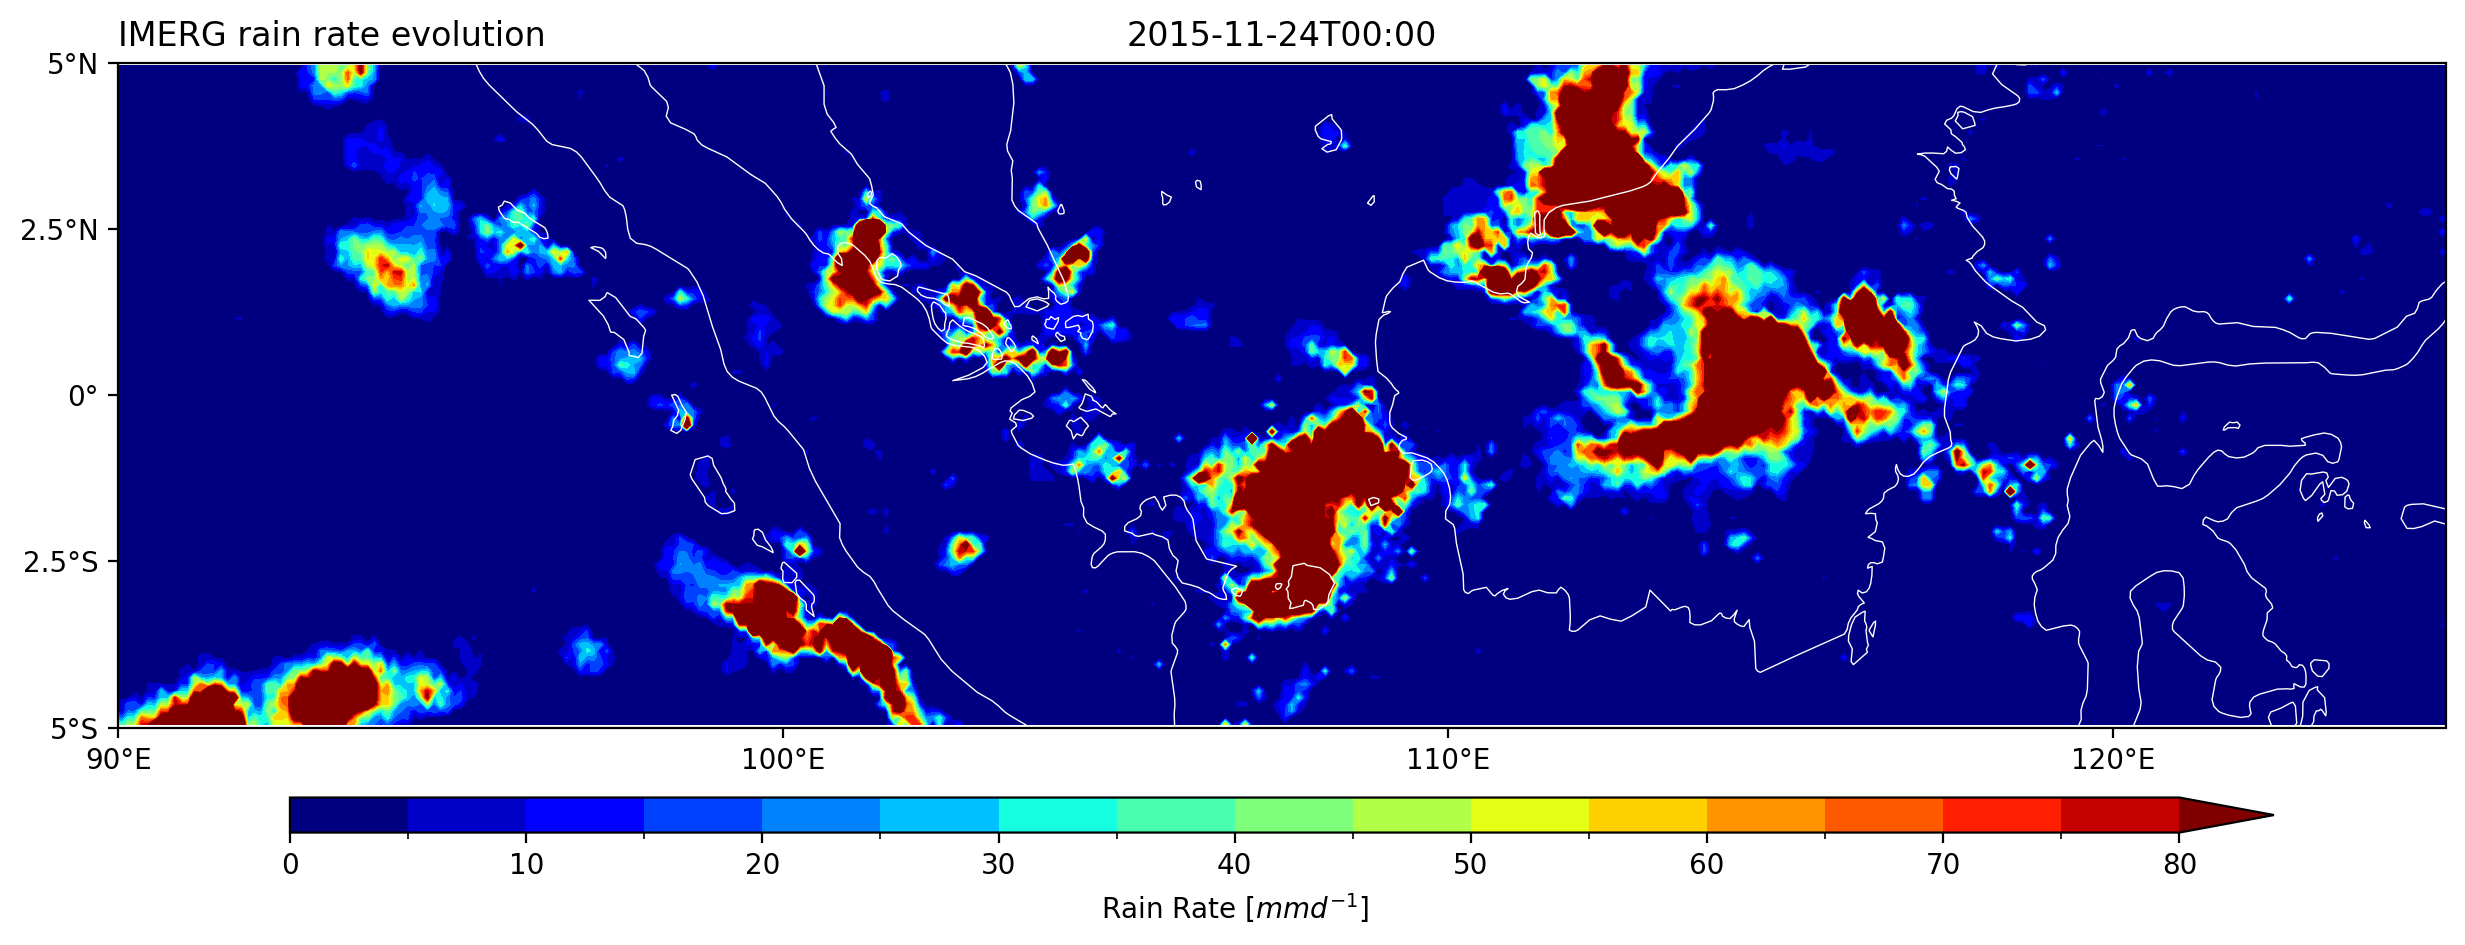

In [22]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
# Data
x = da_RR_IMERG.sel(
    time=slice('2015-11-24 00:00','2015-11-25 00:00',2)
)*24    # mm/day

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='w', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [0,85]
dl = 5

cf = x[0,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 


ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')

for i in range(1):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 
    ax1.set_title('IMERG rain rate evolution',loc='left')
    ax1.set_title(np.datetime_as_string(x.time[i],unit='m'))
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # plt.savefig('plots/IMERG'+np.datetime_as_string(x.time[i],unit='m')+'.png',dpi=300)

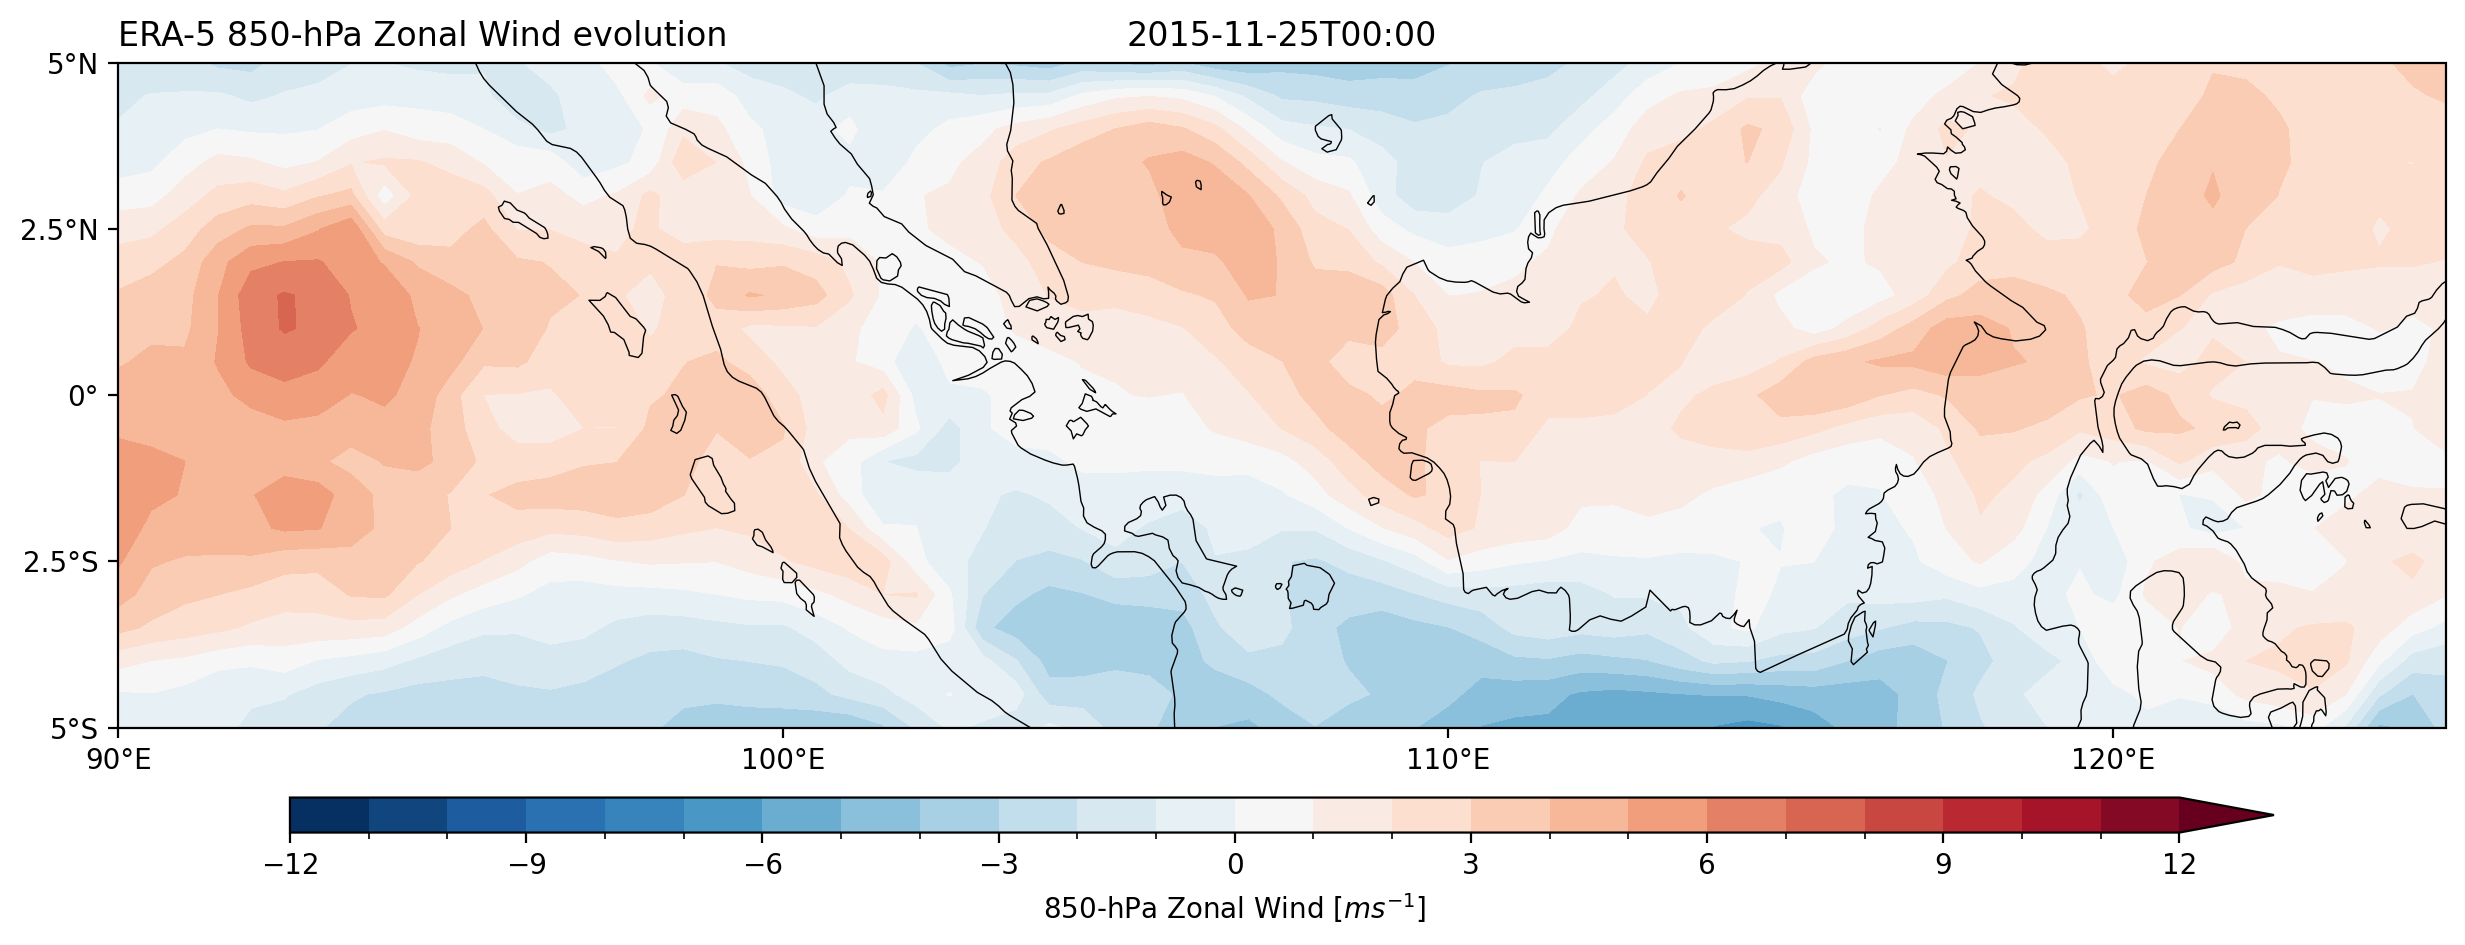

In [32]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
# Data
x = da_U850.sel(
    time=slice('2015-11-24 00:00','2015-11-25 00:00')
)    # m/s

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='k', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [-12,13]
dl = 1

cf = x[0,:,:].plot.contourf(
        ax=ax1,
        x='longitude',
        y='latitude',
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='max',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        
        ) 


ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('850-hPa Zonal Wind [$m s^{-1}$]')

for i in range(5):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        x='longitude',
        y='latitude',
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='max',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 
    ax1.set_title('ERA-5 850-hPa Zonal Wind evolution',loc='left')
    ax1.set_title(np.datetime_as_string(x.time[i],unit='m'))
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # plt.savefig('temp_plots/ERA5_U850_'+np.datetime_as_string(x.time[i],unit='m')+'.png',dpi=300)

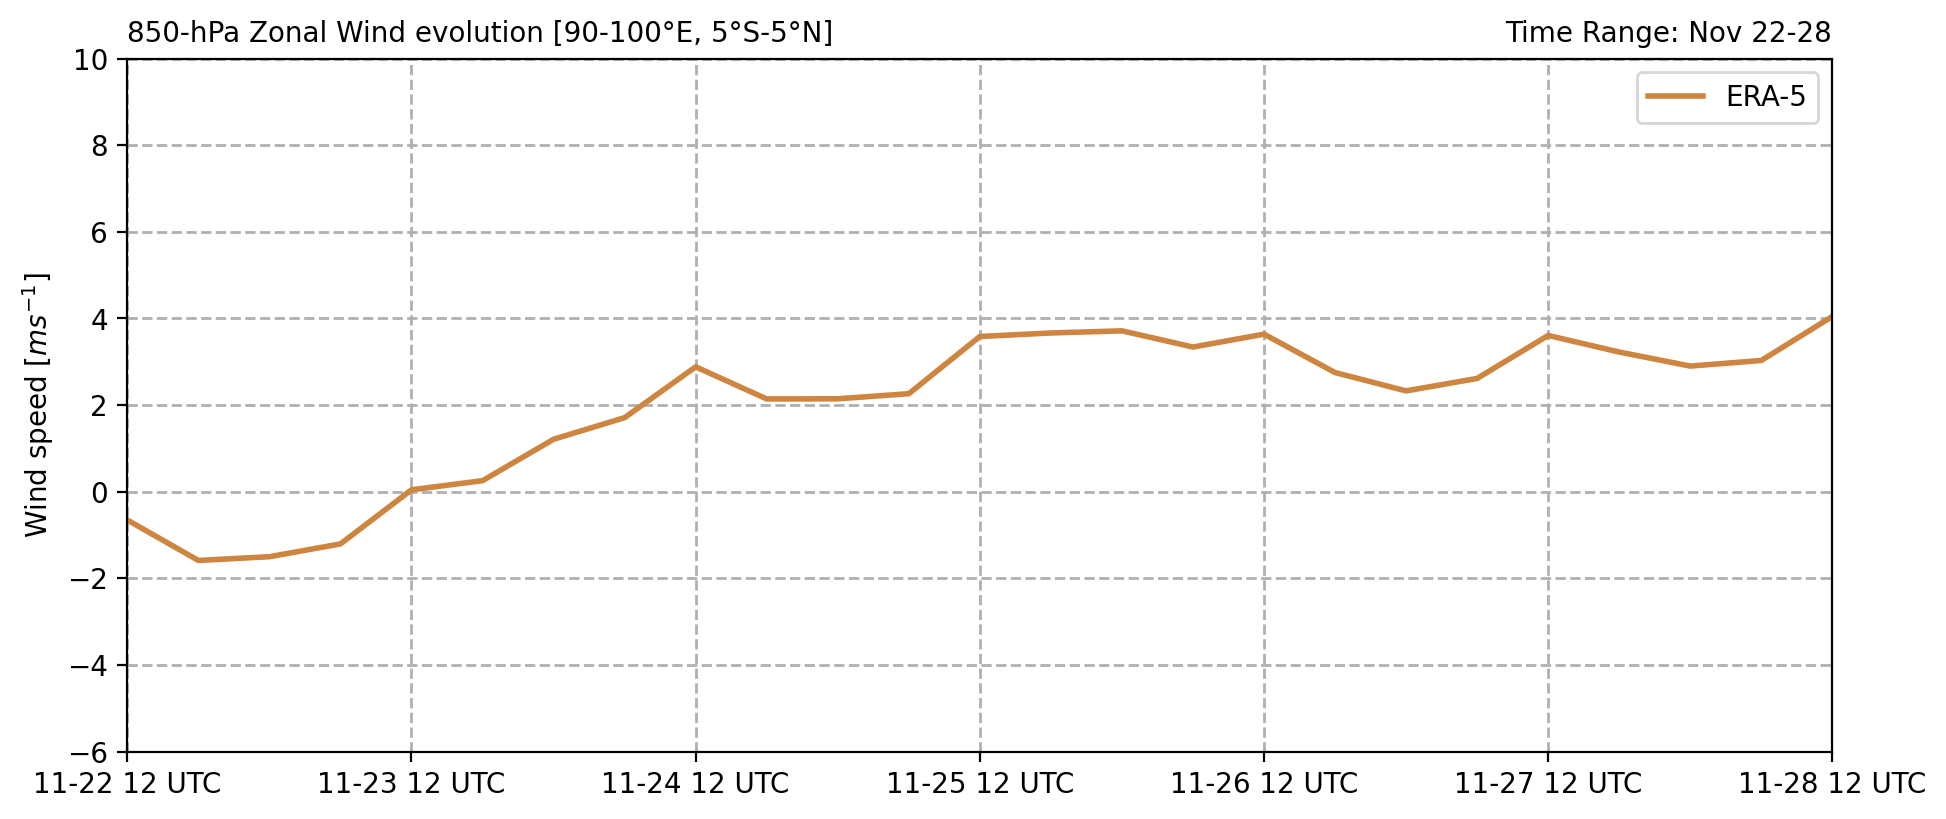

In [11]:
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

# Average zonal wind speed at 850-hPa between 80-90°E
x1 = da_U850.where(
    (da_U850.latitude>lat_avg_bound[0]) & (da_U850.latitude<lat_avg_bound[1]) 
    & (da_U850.longitude>lon_bound_d01[0]+10) & (da_U850.longitude<lon_bound_d02[0]+10),
    drop=True).mean('latitude').mean('longitude')

a = x1.plot.line(
    ax=ax1,
    xlim=[x1.time[2],x1.time[-2]],
    ylim=[-6,10],
    color='peru',
    linewidth=2,
    linestyle = '-'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('850-hPa Zonal Wind evolution [90-100°E, 5°S-5°N]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov 22-28', loc='right', fontsize=10)
ax1.set_title('')
ax1.tick_params(rotation=0)
ax1.set_xticks(x1.time[2::4],np.array(x1.time[2::4].dt.strftime("%m-%d %H UTC")), horizontalalignment='center')
ax1.set_xlabel('')
ax1.set_ylabel('Wind speed [$m s^{-1}$]')
ax1.legend(['ERA-5'], loc='upper right')


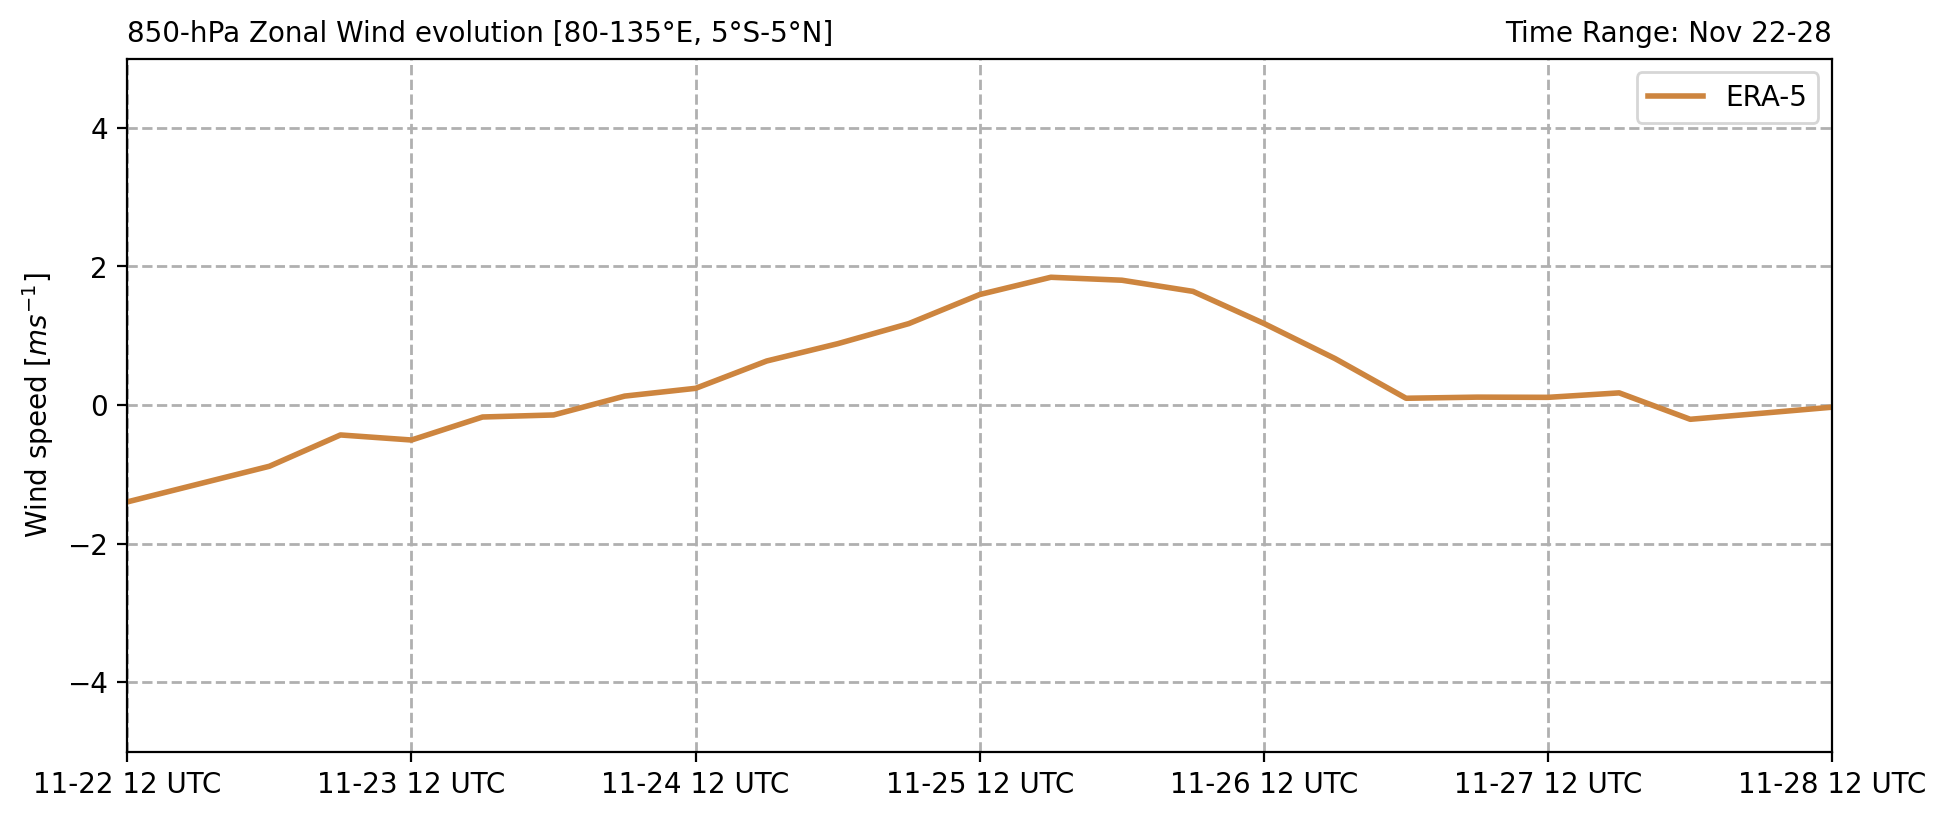

In [49]:
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

# Average zonal wind speed at 850-hPa between 80-90°E
x1 = da_U850.where(
    (da_U850.latitude>lat_avg_bound[0]) & (da_U850.latitude<lat_avg_bound[1]),
    drop=True).mean('latitude').mean('longitude')

a = x1.plot.line(
    ax=ax1,
    xlim=[x1.time[2],x1.time[-2]],
    ylim=[-5,5],
    color='peru',
    linewidth=2,
    linestyle = '-'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('850-hPa Zonal Wind evolution [80-135°E, 5°S-5°N]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov 22-28', loc='right', fontsize=10)
ax1.set_title('')
ax1.tick_params(rotation=0)
ax1.set_xticks(x1.time[2::4],np.array(x1.time[2::4].dt.strftime("%m-%d %H UTC")), horizontalalignment='center')
ax1.set_xlabel('')
ax1.set_ylabel('Wind speed [$m s^{-1}$]')
ax1.legend(['ERA-5'], loc='upper right')


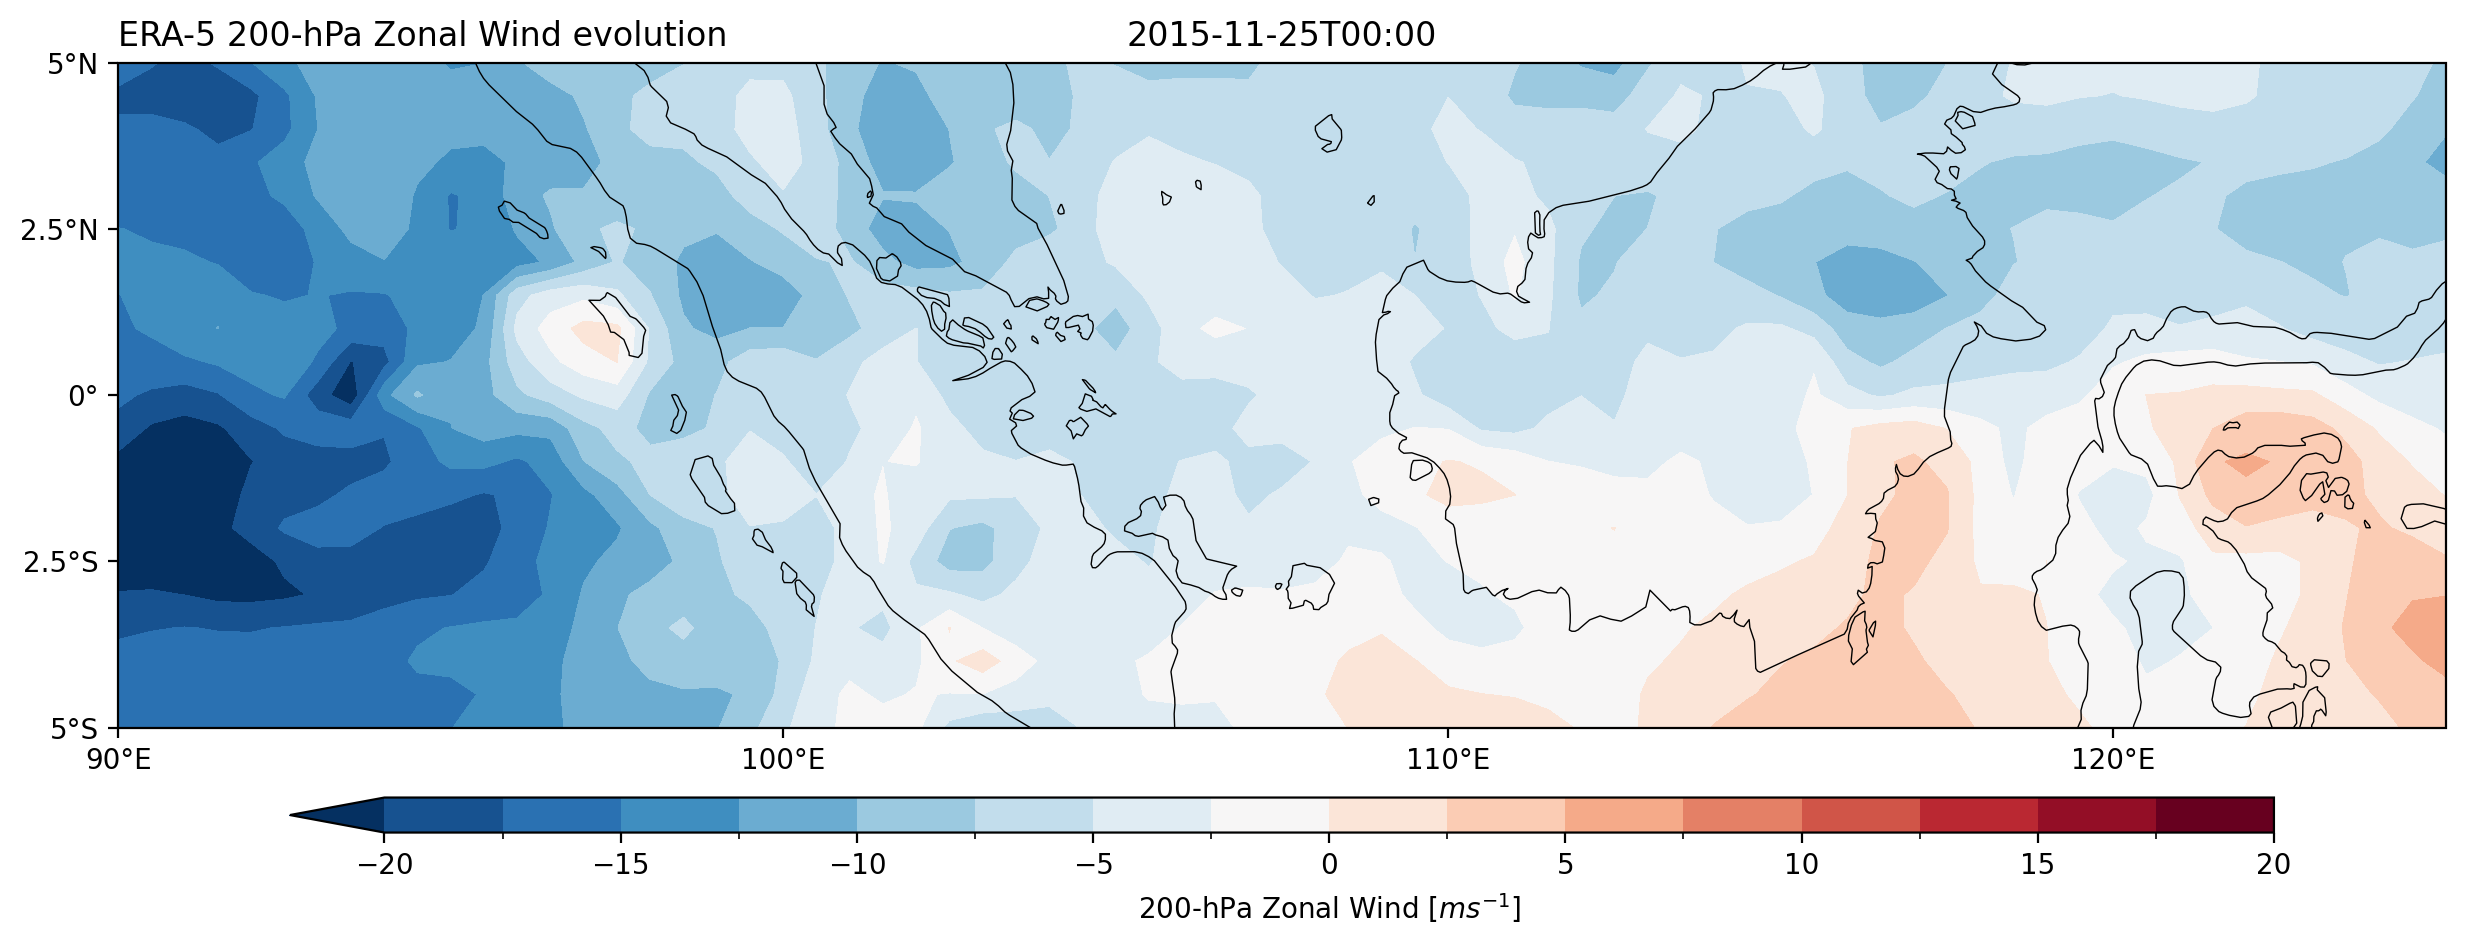

In [48]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
# Data
x = da_U200.sel(
    time=slice('2015-11-24 00:00','2015-11-25 00:00')
)    # m/s

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='k', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [-20,22.5]
dl = 2.5

cf = x[0,:,:].plot.contourf(
        ax=ax1,
        x='longitude',
        y='latitude',
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='min',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 


ax2 = fig.add_subplot(gs[1,1])
# offset = mcolors.TwoSlopeNorm(vmin=levels[0], vcenter=0, vmax=levels[1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('200-hPa Zonal Wind [$m s^{-1}$]')

for i in range(5):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        x='longitude',
        y='latitude',
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='min',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 
    ax1.set_title('ERA-5 200-hPa Zonal Wind evolution',loc='left')
    ax1.set_title(np.datetime_as_string(x.time[i],unit='m'))
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # plt.savefig('temp_plots/ERA5_U200_'+np.datetime_as_string(x.time[i],unit='m')+'.png',dpi=300)

## Diurnal Composites

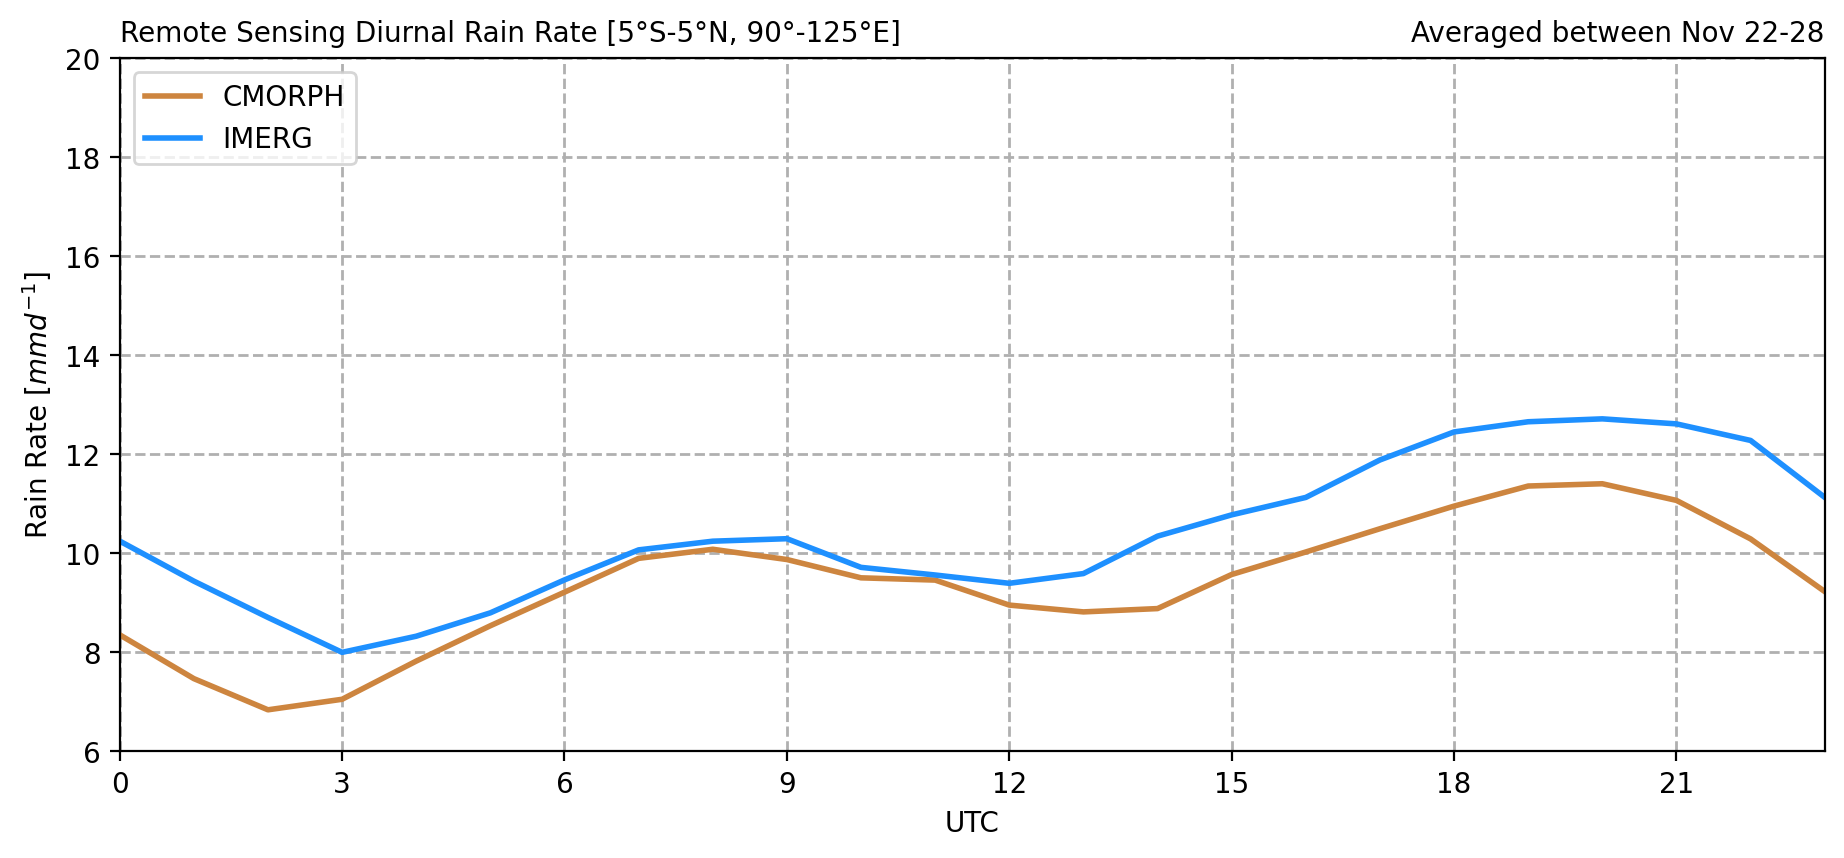

In [20]:
# CMORPH
da = da_RR_CMORPH.where((da_RR_CMORPH.lon>lon_bound_d02[0]) & (da_RR_CMORPH.lon<lon_bound_d02[1])
                       & (da_RR_CMORPH.lat>lat_bound[0]) & (da_RR_CMORPH.lat<lat_bound[1]), drop=True)*24
da_avg = da.mean('lat').mean('lon')
x1 = da_avg.groupby('time.hour').mean()

# IMERG
da = da_RR_IMERG.where((da_RR_IMERG.lon>lon_bound_d02[0]) & (da_RR_IMERG.lon<lon_bound_d02[1])
                       & (da_RR_IMERG.lat>lat_bound[0]) & (da_RR_IMERG.lat<lat_bound[1]), drop=True)*24
da_avg = da.mean('lat').mean('lon')
x2 = da_avg.groupby('time.hour').mean()

fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x1.plot.line(
    ax=ax1,
    xlim=[0,x1.shape[0]-1],
    ylim=[6,20],
    color='peru',
    linewidth=2,
    linestyle='-',
    label='CMORPH'
)
b = x2.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle='-',
    label='IMERG'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('Remote Sensing Diurnal Rain Rate [5°S-5°N, 90°-125°E]', loc='left', fontsize=10)
ax1.set_title('Averaged between Nov 22-28', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(np.arange(0,24,3))
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(loc='upper left')


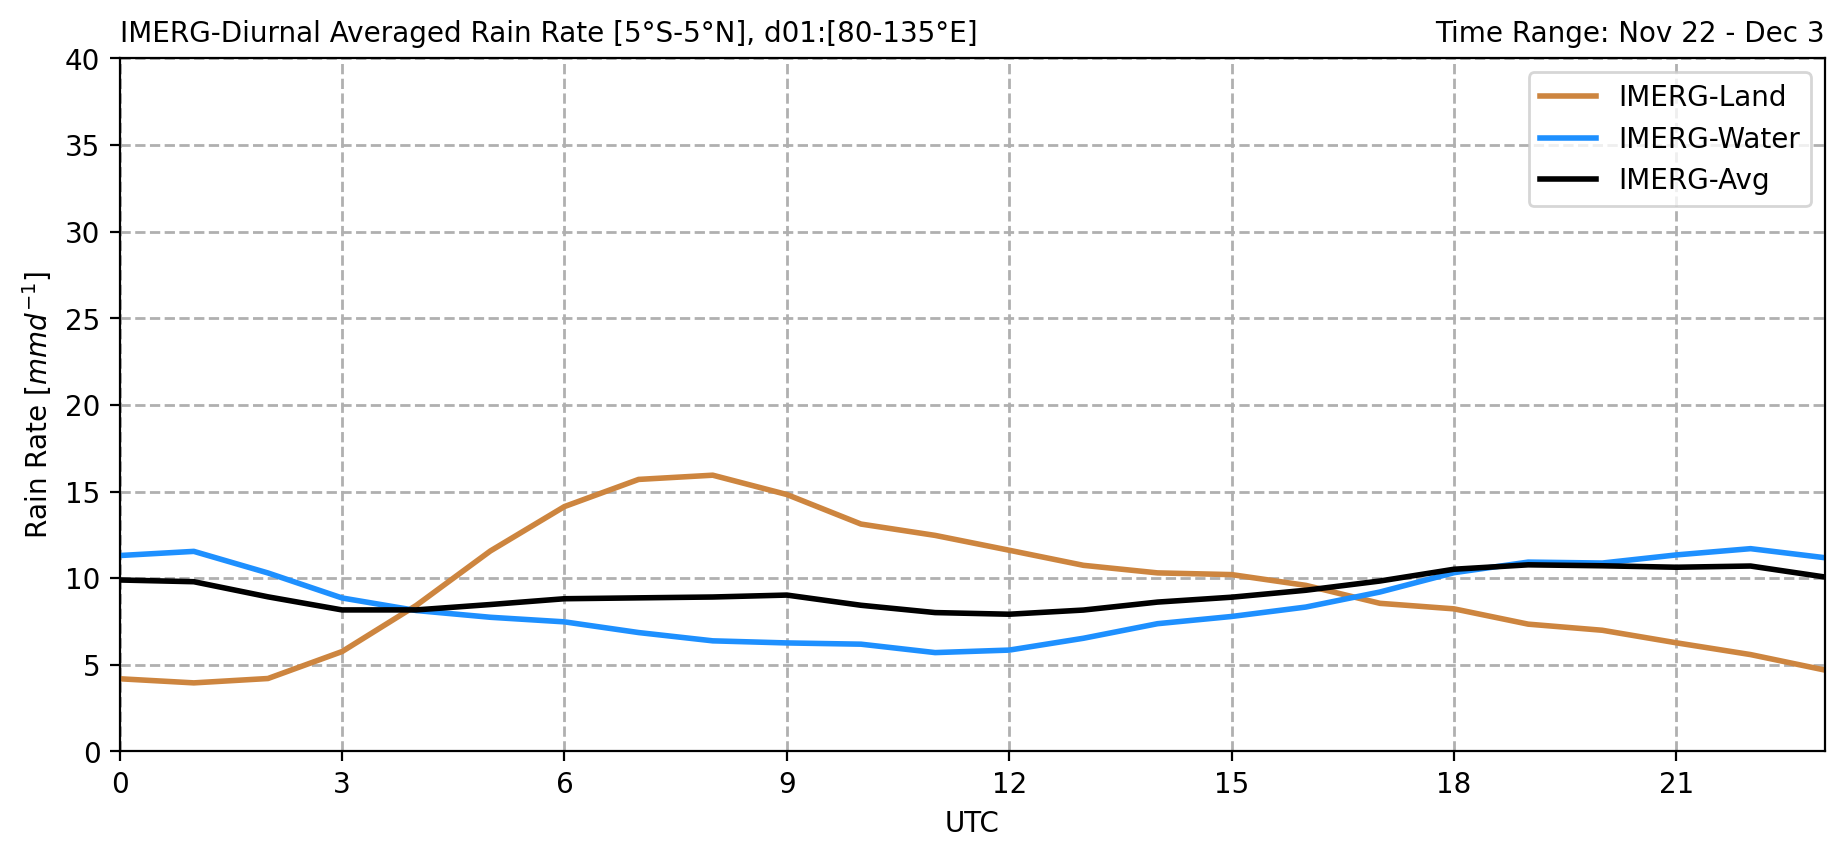

In [13]:
################### IMERG ##################

#################### d01 ###################
da = da_RR_IMERG.where((da_RR_IMERG.lon>lon_bound_d01[0]) & (da_RR_IMERG.lon<lon_bound_d01[1])
                       & (da_RR_IMERG.lat>lat_bound[0]) & (da_RR_IMERG.lat<lat_bound[1]), drop=False)*24

# LAND 
da_avg = da.where(da_Mask_IMERG<50, drop=False).mean('lat').mean('lon')
da_avg = da_avg.assign_coords(Time=(['time'],da.time.values))
x1L = da_avg.groupby('time.hour').mean()
# Water 
da_avg = da.where(da_Mask_IMERG>50,drop=False).mean('lat').mean('lon')
da_avg = da_avg.assign_coords(Time=(['time'],da.time.values))
x1W = da_avg.groupby('time.hour').mean()
# Average
da_avg = da.mean('lat').mean('lon')
x1A = da_avg.groupby('time.hour').mean()

#################### d02 ###################
da = da_RR_IMERG.where((da_RR_IMERG.lon>lon_bound_d02[0]) & (da_RR_IMERG.lon<lon_bound_d02[1])
                       & (da_RR_IMERG.lat>lat_bound[0]) & (da_RR_IMERG.lat<lat_bound[1]), drop=False)*24

# LAND 
da_avg = da.where(da_Mask_IMERG<50, drop=False).mean('lat').mean('lon')
da_avg = da_avg.assign_coords(Time=(['time'],da.time.values))
x2L = da_avg.groupby('time.hour').mean()
# Water 
da_avg = da.where(da_Mask_IMERG>50,drop=False).mean('lat').mean('lon')
da_avg = da_avg.assign_coords(Time=(['time'],da.time.values))
x2W = da_avg.groupby('time.hour').mean()
# Average
da_avg = da.mean('lat').mean('lon')
x2A = da_avg.groupby('time.hour').mean()


## PLOTTING ##
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x1L.plot.line(
    ax=ax1,
    xlim=[0,23],
    ylim=[0,40],
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='IMERG-Land'
)
b = x1W.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='IMERG-Water'
)
c = x1A.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='k',
    linewidth=2,
    linestyle = '-',
	label='IMERG-Avg'
)
# d = x2L.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     ylim=[0,40],
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='IMERG-Land'
# )
# e = x2W.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='IMERG-Water'
# )
# f = x2A.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     color='k',
#     linewidth=2,
#     linestyle = '-',
# 	label='IMERG-Avg'
# )

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
# ax1.set_title('IMERG-Diurnal Averaged Rain Rate [5°S-5°N], d02:[90-125°E]', loc='left', fontsize=10)
ax1.set_title('IMERG-Diurnal Averaged Rain Rate [5°S-5°N], d01:[80-135°E]', loc='left', fontsize=10)
# ax1.set_title('IMERG-Diurnal Averaged Rain Rate [5°S-5°N], d01:[80-135°E], d02:[90-125°E]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov 22 - Dec 3', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(np.arange(0,24,3))
# ax2.set_yticklabels(t.values)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend()


In [ ]:
# da = da[0:72+1,...]

# LAND 
da_avg = da.where(da_Mask_IMERG<50, drop=False).mean('lat').mean('lon')
da_avg = da_avg.assign_coords(Time=(['time'],da.time.values))
x2L = da_avg.groupby('time.hour').mean()
# Water 
da_avg = da.where(da_Mask_IMERG>50,drop=False).mean('lat').mean('lon')
da_avg = da_avg.assign_coords(Time=(['time'],da.time.values))
x2W = da_avg.groupby('time.hour').mean()
# Average
da_avg = da.mean('lat').mean('lon')
x2A = da_avg.groupby('time.hour').mean()


## PLOTTING ##
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

# a = x1L.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     ylim=[0,40],
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='d01-Land'
# )
# b = x1W.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='d01-Water'
# )
# c = x1A.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     color='k',
#     linewidth=2,
#     linestyle = '-',
# 	label='d01-Avg'
# )
d = x2L.plot.line(
    ax=ax1,
    xlim=[0,23],
    ylim=[0,40],
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='IMERG-Land'
)
e = x2W.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='IMERG-Water'
)
f = x2A.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='k',
    linewidth=2,
    linestyle = '-',
	label='IMERG-Avg'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('IMERG-Diurnal Averaged Rain Rate [5°S-5°N], d02:[90-125°E]', loc='left', fontsize=10)
# ax1.set_title('IMERG-Diurnal Averaged Rain Rate [5°S-5°N], d01:[80-135°E], d02:[90-125°E]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov 22-24', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(np.arange(0,24,3))
# ax2.set_yticklabels(t.values)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend()


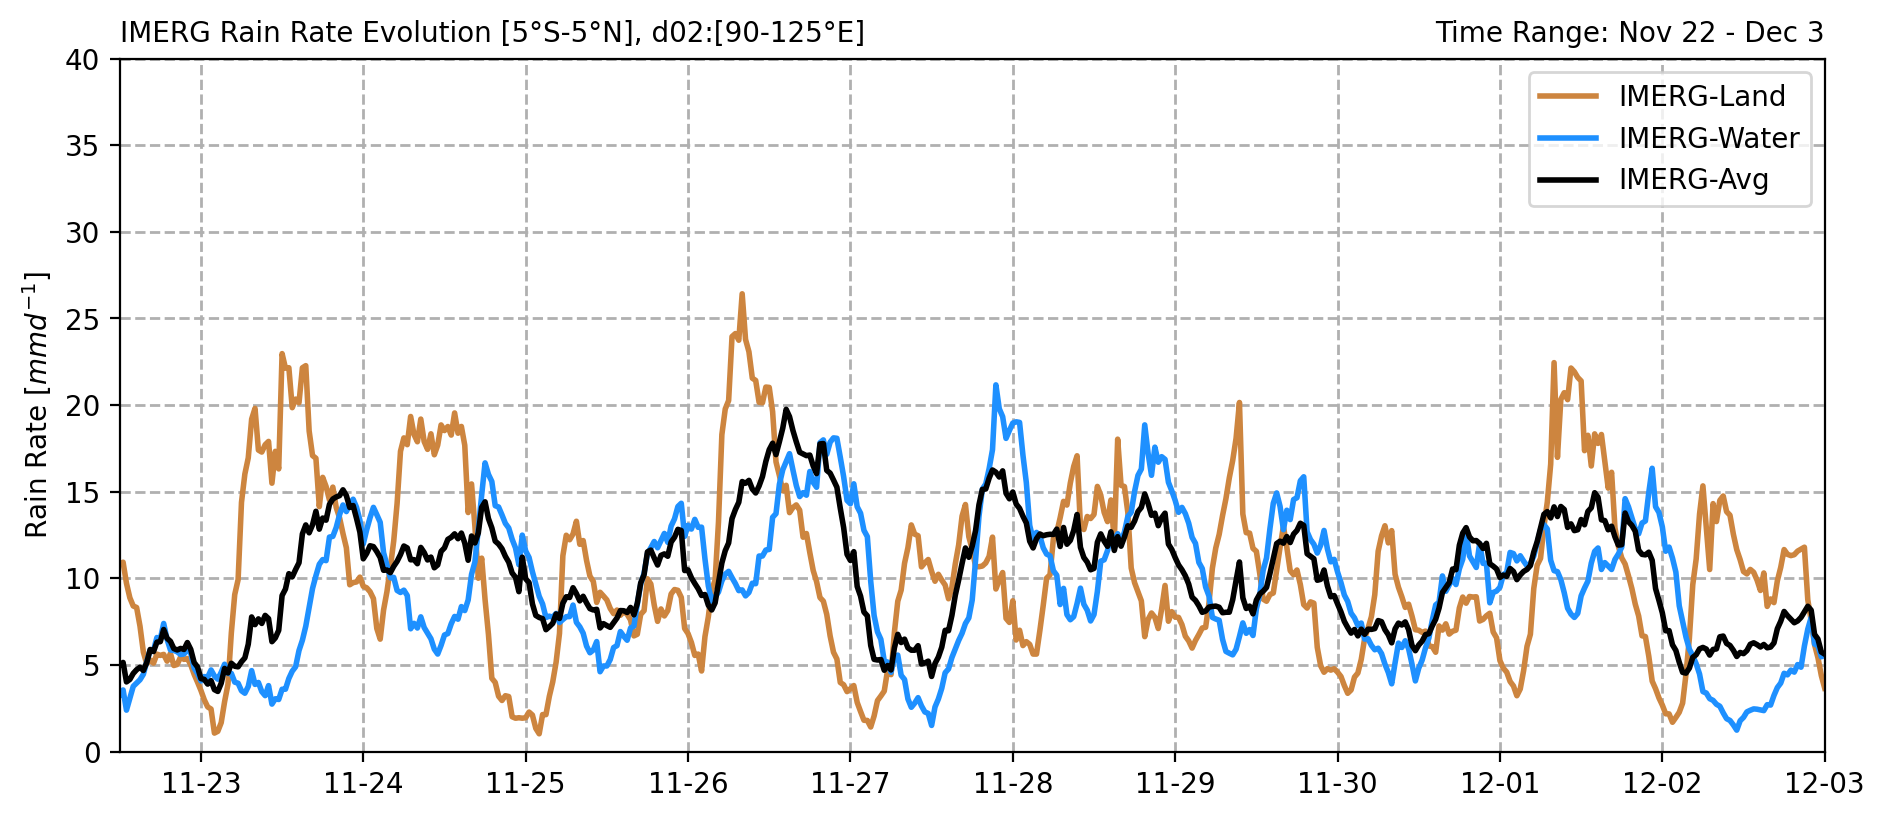

In [24]:
################### IMERG ##################

#################### d01 ###################
da = da_RR_IMERG.where((da_RR_IMERG.lon>lon_bound_d01[0]) & (da_RR_IMERG.lon<lon_bound_d01[1])
                       & (da_RR_IMERG.lat>lat_bound[0]) & (da_RR_IMERG.lat<lat_bound[1]), drop=False)*24
# da = da[0:72+1,...]

# LAND 
da_avg = da.where(da_Mask_IMERG<50, drop=False).mean('lat').mean('lon')
x1L = da_avg.assign_coords(Time=(['time'],da.time.values))

# Water 
da_avg = da.where(da_Mask_IMERG>50,drop=False).mean('lat').mean('lon')
x1W = da_avg.assign_coords(Time=(['time'],da.time.values))
# Average
x1A = da.mean('lat').mean('lon')

#################### d02 ###################
da = da_RR_IMERG.where((da_RR_IMERG.lon>lon_bound_d02[0]) & (da_RR_IMERG.lon<lon_bound_d02[1])
                       & (da_RR_IMERG.lat>lat_bound[0]) & (da_RR_IMERG.lat<lat_bound[1]), drop=False)*24
# da = da[0:72+1,...]

# LAND 
da_avg = da.where(da_Mask_IMERG<50, drop=False).mean('lat').mean('lon')
x2L = da_avg.assign_coords(Time=(['time'],da.time.values))
# Water 
da_avg = da.where(da_Mask_IMERG>50,drop=False).mean('lat').mean('lon')
x2W = da_avg.assign_coords(Time=(['time'],da.time.values))
# Average
x2A = da.mean('lat').mean('lon')


## PLOTTING ##
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

# a = x1L.plot.line(
#     ax=ax1,
#     ylim=[0,40],
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='d01-Land'
# )
# b = x1W.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='d01-Water'
# )
# c = x1A.plot.line(
#     ax=ax1,
#     color='k',
#     linewidth=2,
#     linestyle = '-',
# 	label='d01-Avg'
# )
d = x2L.plot.line(
    ax=ax1,
    ylim=[0,40],
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='IMERG-Land'
)
e = x2W.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='IMERG-Water'
)
f = x2A.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='IMERG-Avg'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('IMERG Rain Rate Evolution [5°S-5°N], d02:[90-125°E]', loc='left', fontsize=10)
# ax1.set_title('IMERG-Diurnal Averaged Rain Rate [5°S-5°N], d01:[80-135°E], d02:[90-125°E]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov 22 - Dec 3', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(x1L.time[24::48])
ax1.set_xlim(x1L.time[0],x1L.time[-1])
ax1.tick_params(rotation=0)
ax1.set_xticklabels(np.array(x1L.time[24::48].dt.strftime("%m-%d")),horizontalalignment='center')
ax1.set_xlabel('')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(loc='upper right')


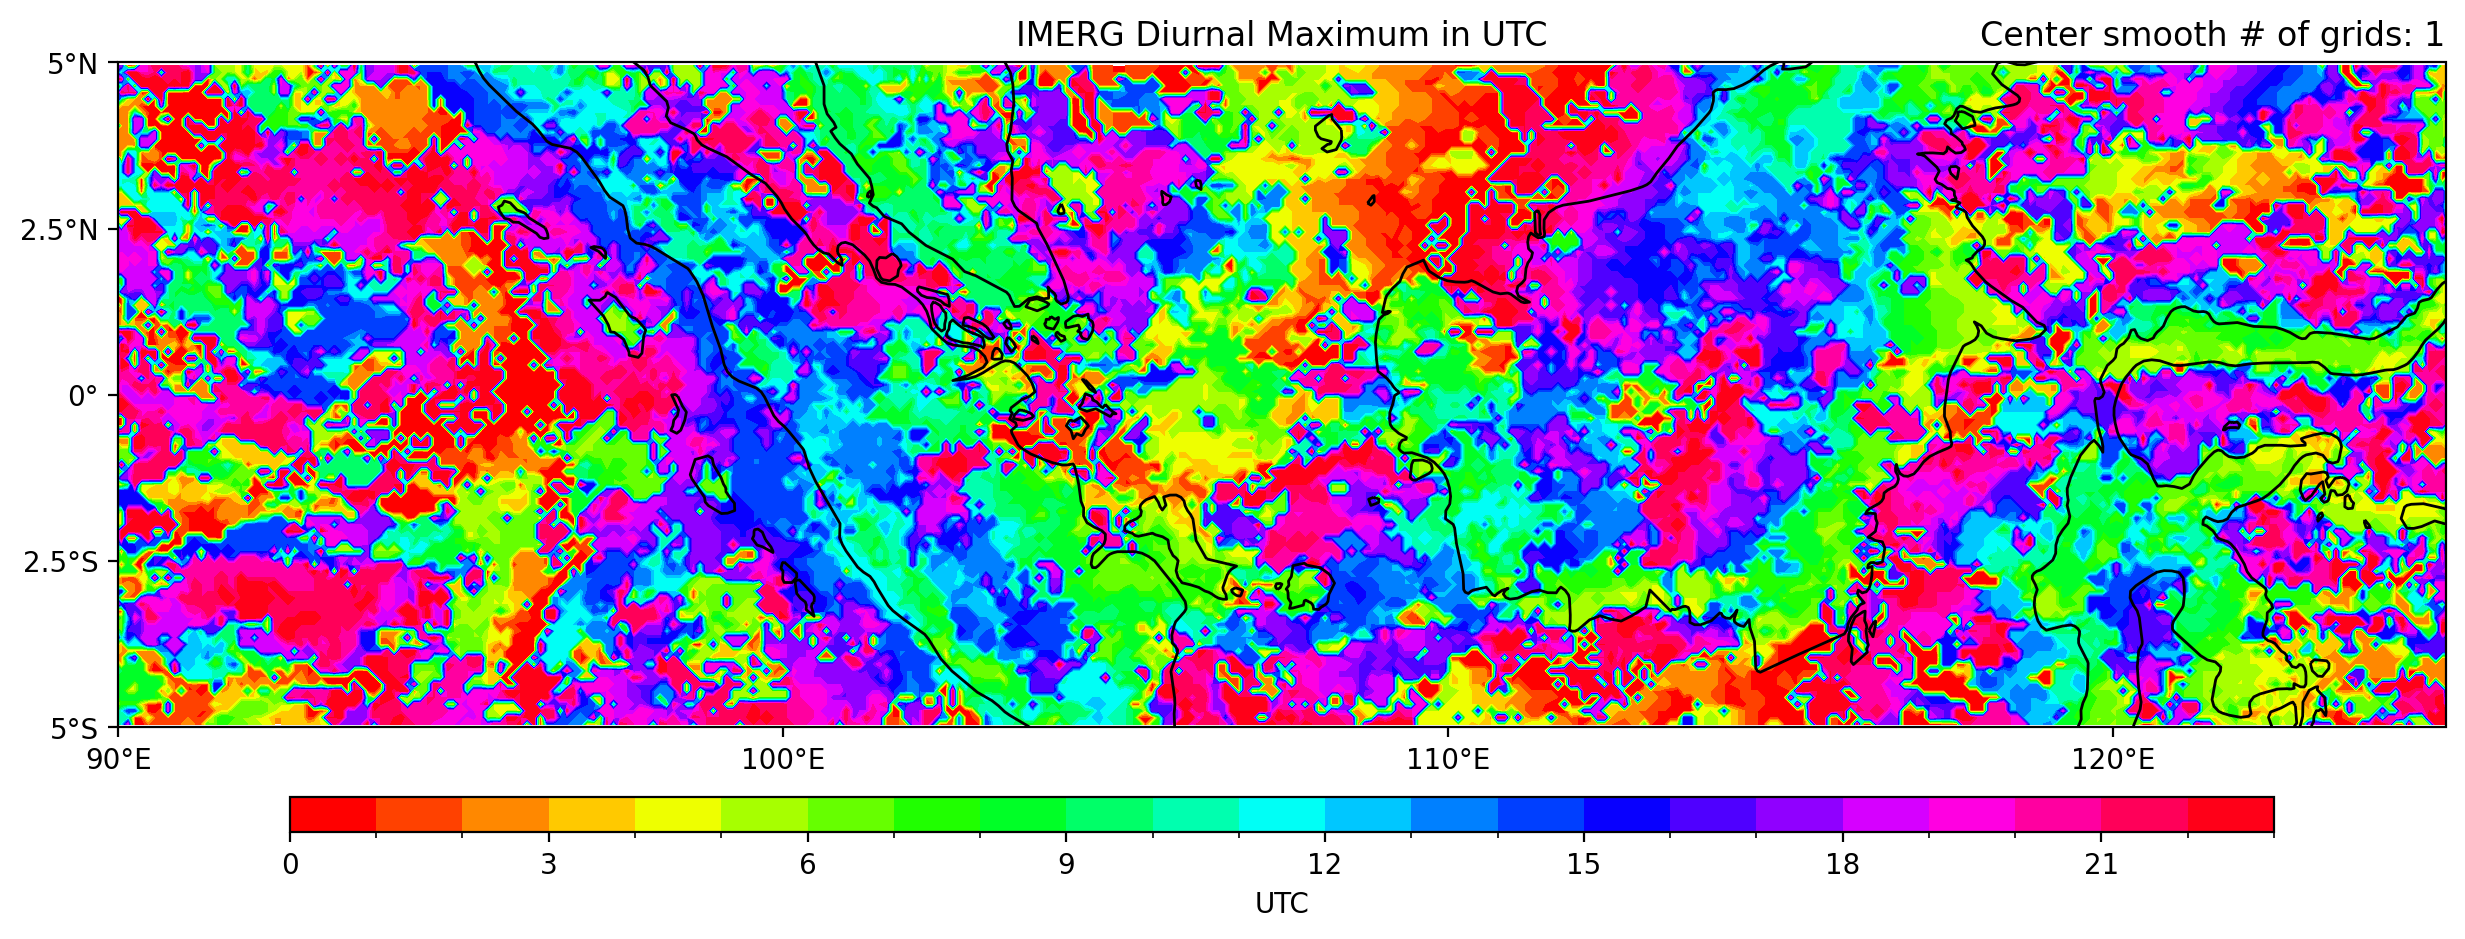

In [27]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
# Data
num_grids = 1
x = da_RR_IMERG
x = x.groupby('time.hour').mean('time')
x = x.rolling(lat=num_grids, min_periods=1, center=True).mean()
x = x.rolling(lon=num_grids, min_periods=1, center=True).mean()
x = x.idxmax('hour',keep_attrs=True)

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [0,24]
dl = 1

cf = x.plot.contourf(
        ax=ax1,
        x='lon',
        y='lat',
        add_colorbar=False,
        cmap='hsv',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 
ax1.set_title('IMERG Diurnal Maximum in UTC',loc='center')
ax1.set_title('Center smooth # of grids: ' + str(num_grids),loc='right')
# ax1.set_title(np.datetime_as_string(x.time[i],unit='m'))
ax1.set_xlabel('')
ax1.set_ylabel('')

ax2 = fig.add_subplot(gs[1,1])
# offset = mcolors.TwoSlopeNorm(vmin=levels[0], vcenter=0, vmax=levels[1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(0,24,3))
cbar.set_label('UTC')
# cbar.ax.set_ticks = np.arange(0,24,3)


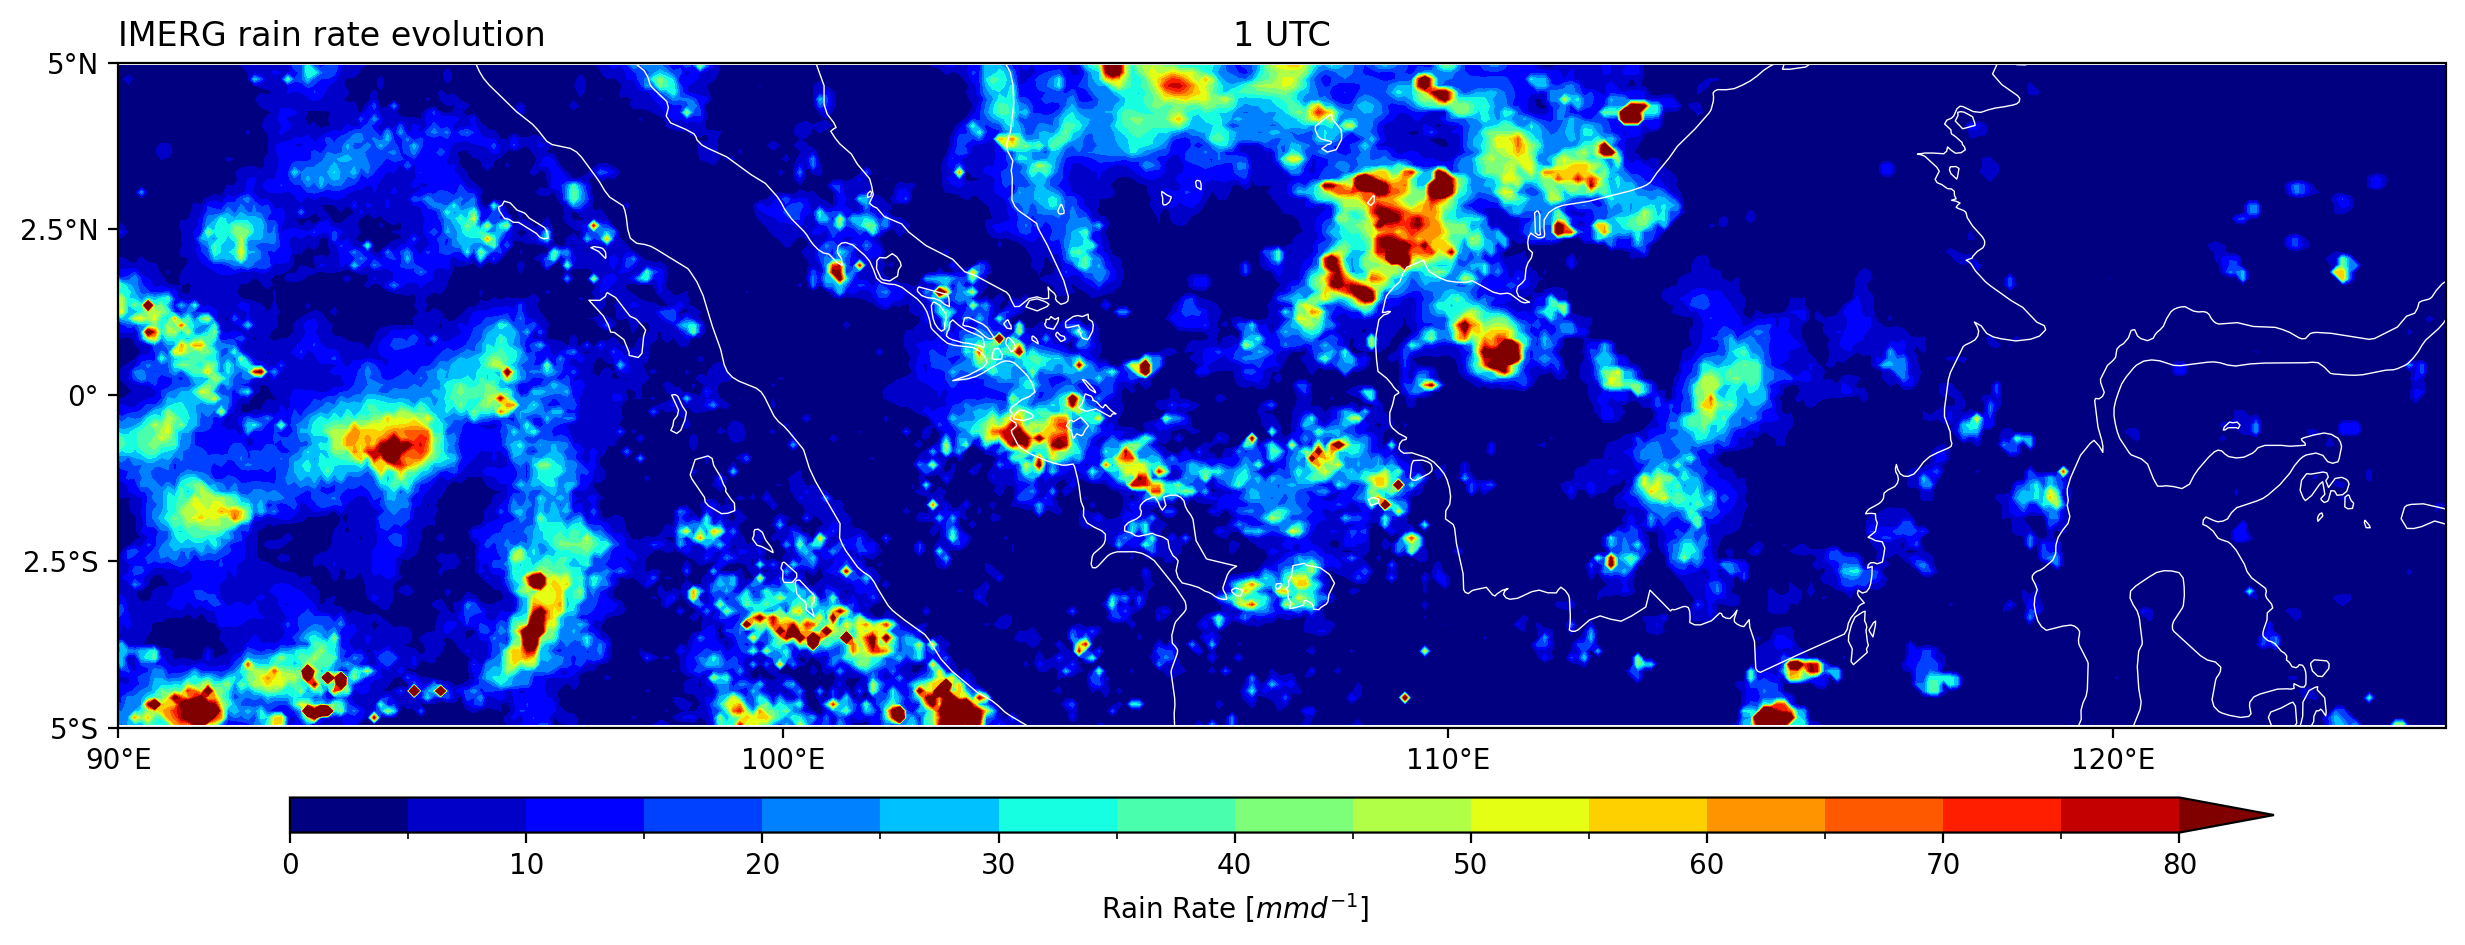

In [ ]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
# Data
x = da_RR_IMERG.groupby('time.hour').mean('time')*24    # mm/day

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='w', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [0,85]
dl = 5

cf = x[0,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')

for i in range(24):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 
    ax1.set_title('IMERG rain rate evolution',loc='left')
    ax1.set_title(str(x.hour[i].values) + ' UTC')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # plt.savefig('temp_plots/IMERG_DC_RR_'+str(x.hour[i].values)+'.png',dpi=300)

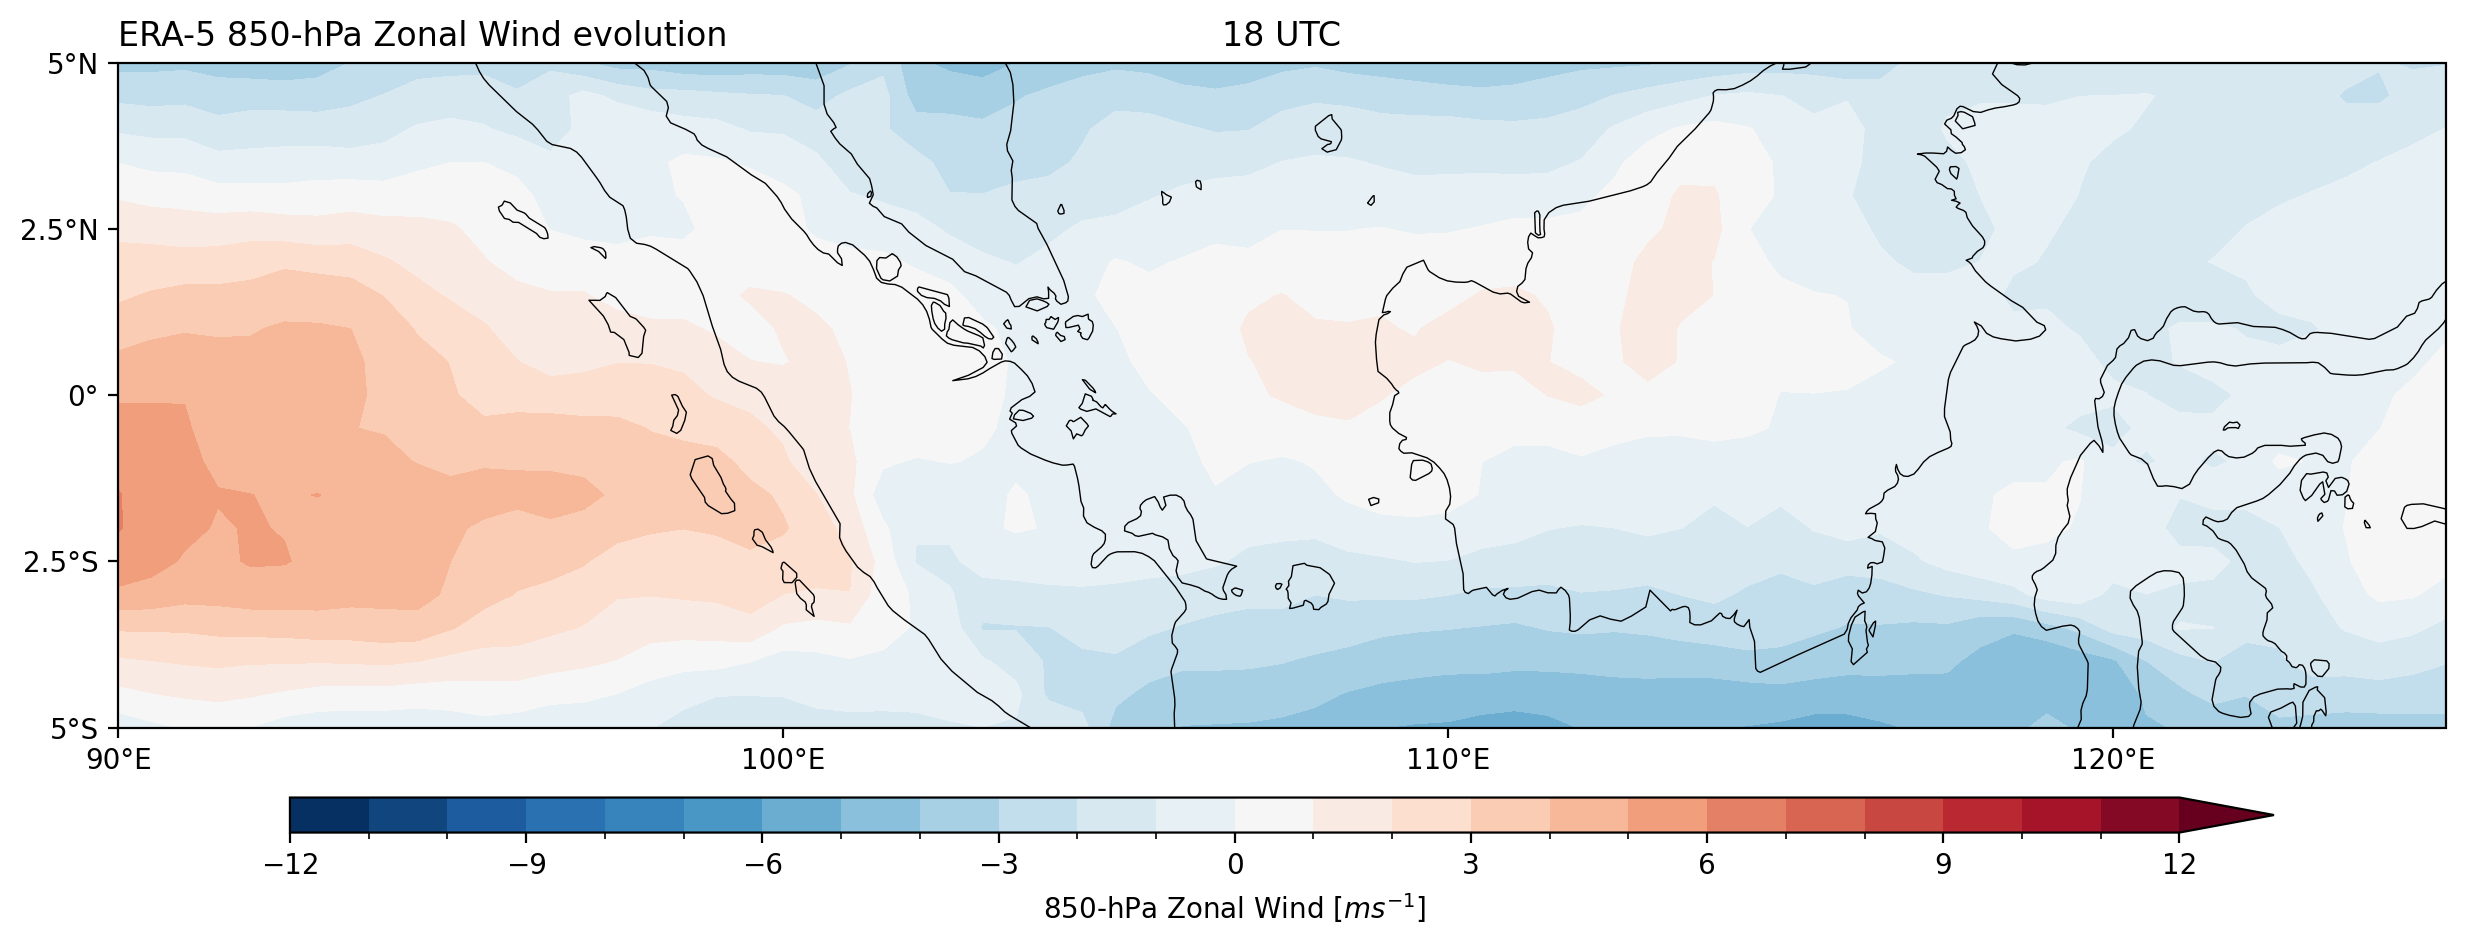

In [ ]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
# Data
x = da_U850.groupby('time.hour').mean('time')    # m/s

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='k', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [-12,13]
dl = 1

cf = x[0,:,:].plot.contourf(
        ax=ax1,
        x='longitude',
        y='latitude',
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='max',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        
        ) 


ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('850-hPa Zonal Wind [$m s^{-1}$]')

for i in range(4):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        x='longitude',
        y='latitude',
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='max',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]]
        ) 
    ax1.set_title('ERA-5 850-hPa Zonal Wind evolution',loc='left')
    ax1.set_title(str(x.hour[i].values) + ' UTC')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    plt.savefig('temp_plots/ERA5_DC_U850_'+str(x.hour[i].values)+'.png',dpi=300)

Text(0, 0.5, '')

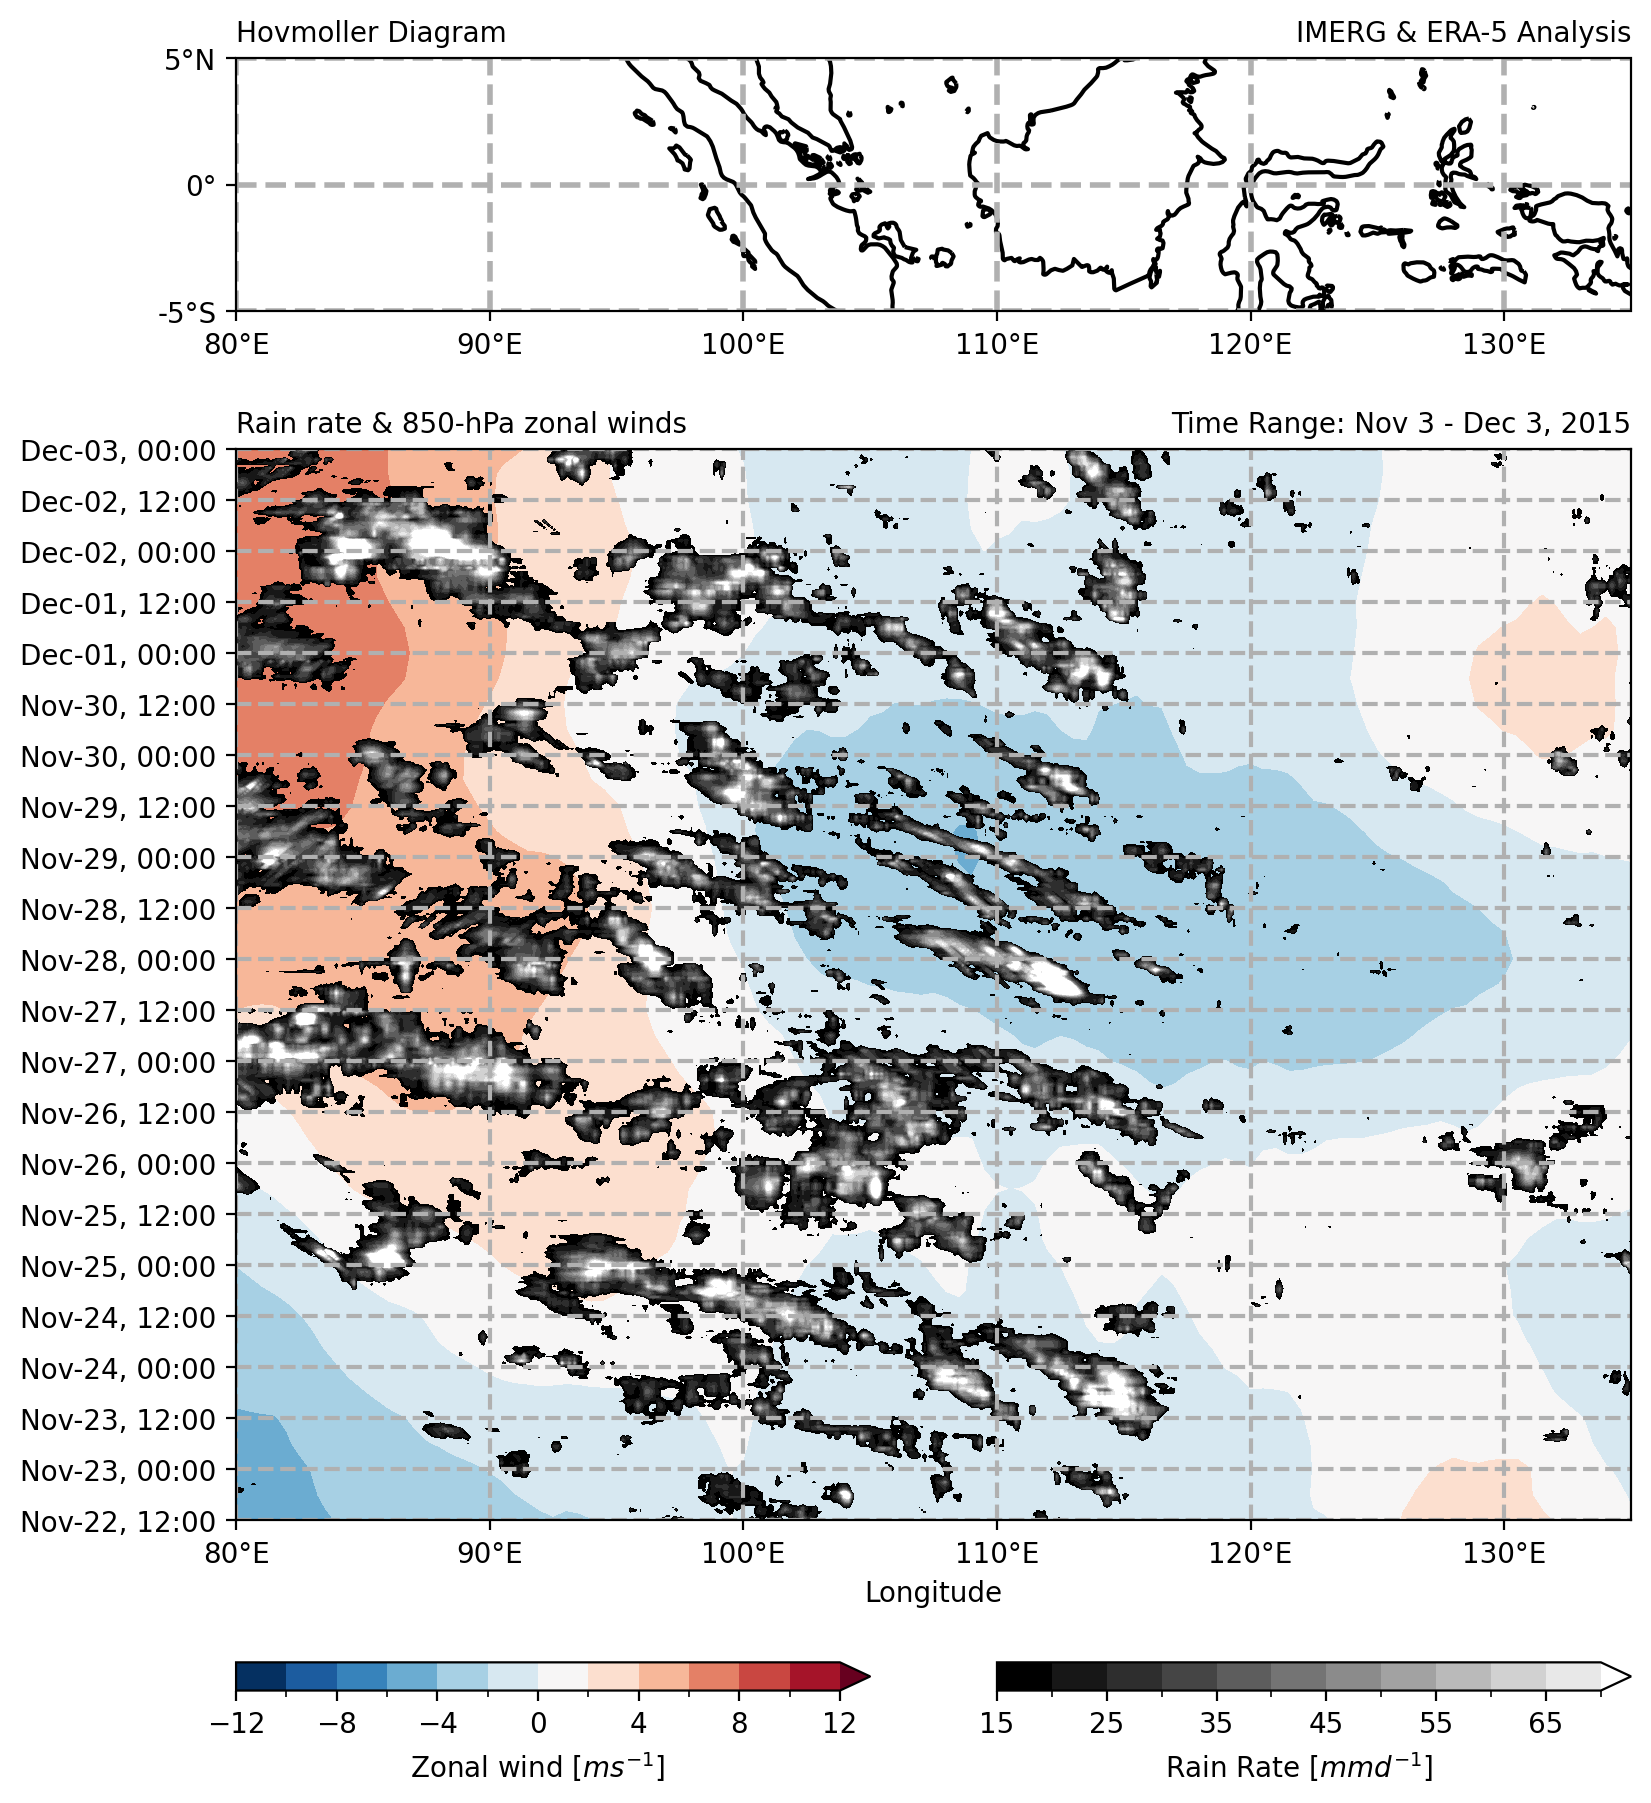

In [33]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1],10))
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E', u'130\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG & ERA-5 Analysis', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = da_RR_IMERG.sel(
	lat=slice(-5,5), 
	time=slice('2015-11-22T12:00','2015-12-03T00:00')
).mean('lat')*24	# Make it rain rate per day instead of hour
# # Change to times for IMERG data to datetime
# 	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
# datetimeindex = x.indexes['time'].to_datetimeindex()
# x = x.assign_coords(time=datetimeindex)

y = da_U850.sel(
	latitude=slice(5,-5),
	time=slice('2015-11-22T12:00','2015-12-03T00:00')
).mean('latitude')
# Apply a rolling center mean for zonal winds
y = y.rolling(time=4*2, min_periods=1, center=True).mean()

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1],10),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)
# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1],10),
	cmap='gray',
	levels=np.arange(15,75,5),
	vmin=15, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22 - Dec 3, 2015', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
# ax2.set_yticks(y.time[0::4])
t = x.time[::24].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x.time[::24])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


Text(0, 0.5, '')

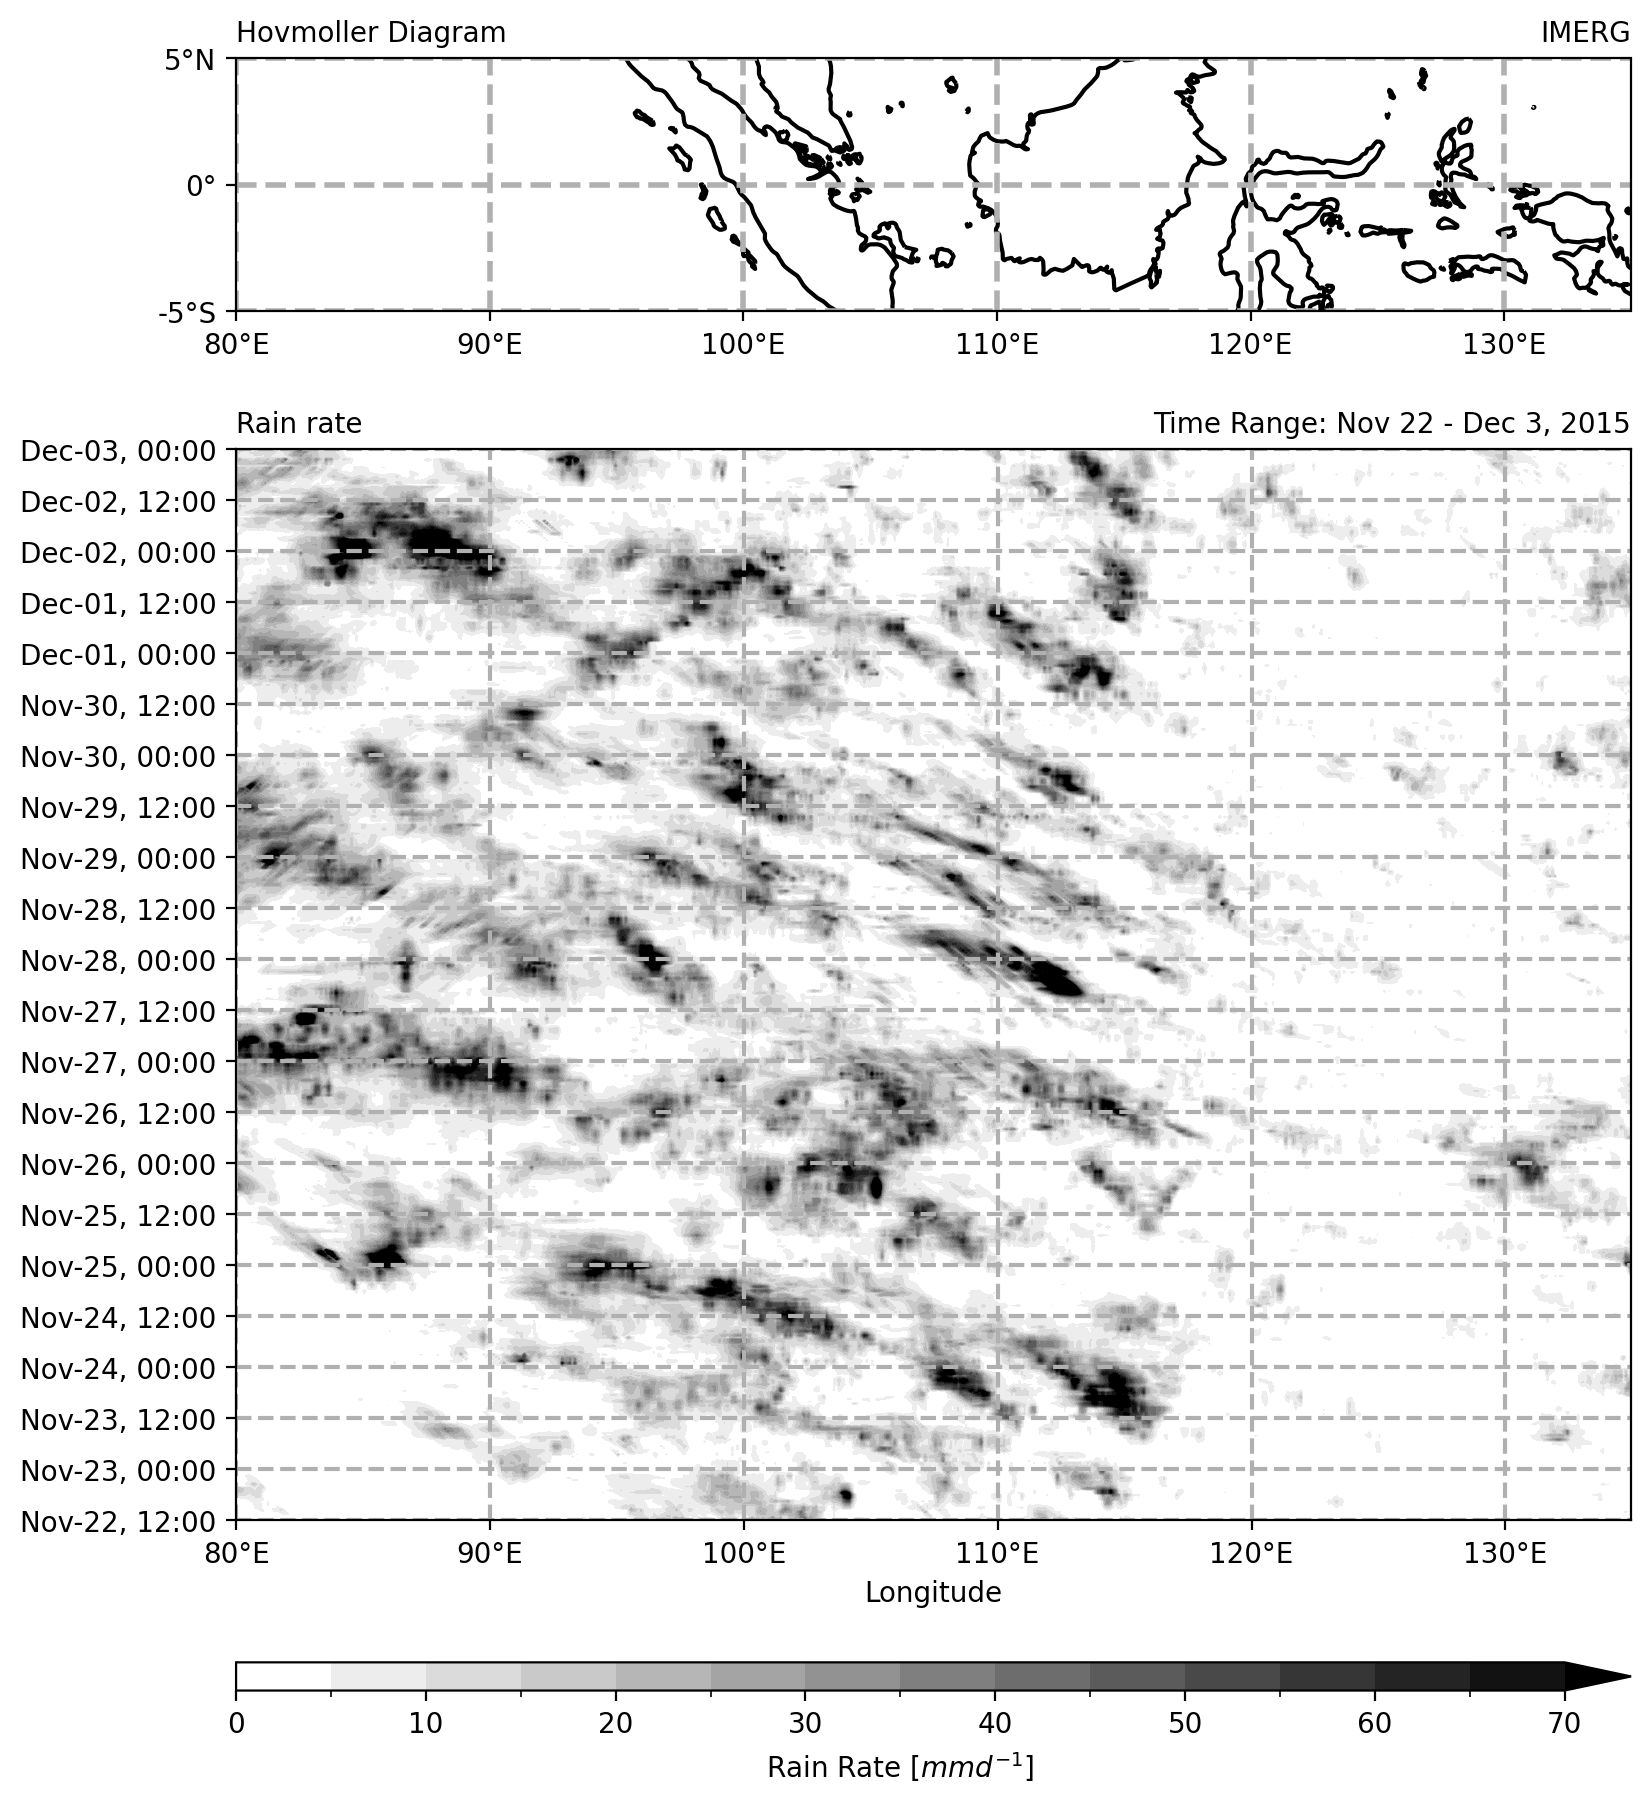

In [34]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1],10))
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E', u'130\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x = da_RR_IMERG.sel(
	lat=slice(-5,5), 
	time=slice('2015-11-22T12:00','2015-12-03T00:00')
).mean('lat')*24	# Make it rain rate per day instead of hour

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1],10),
	cmap='gray_r',
	levels=np.arange(0,75,5),
	vmin=0, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22 - Dec 3, 2015', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
# ax2.set_yticks(y.time[0::4])
t = x.time[::24].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x.time[::24])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')


### Diurnal Hovmoller Composites

Text(0, 0.5, 'UTC')

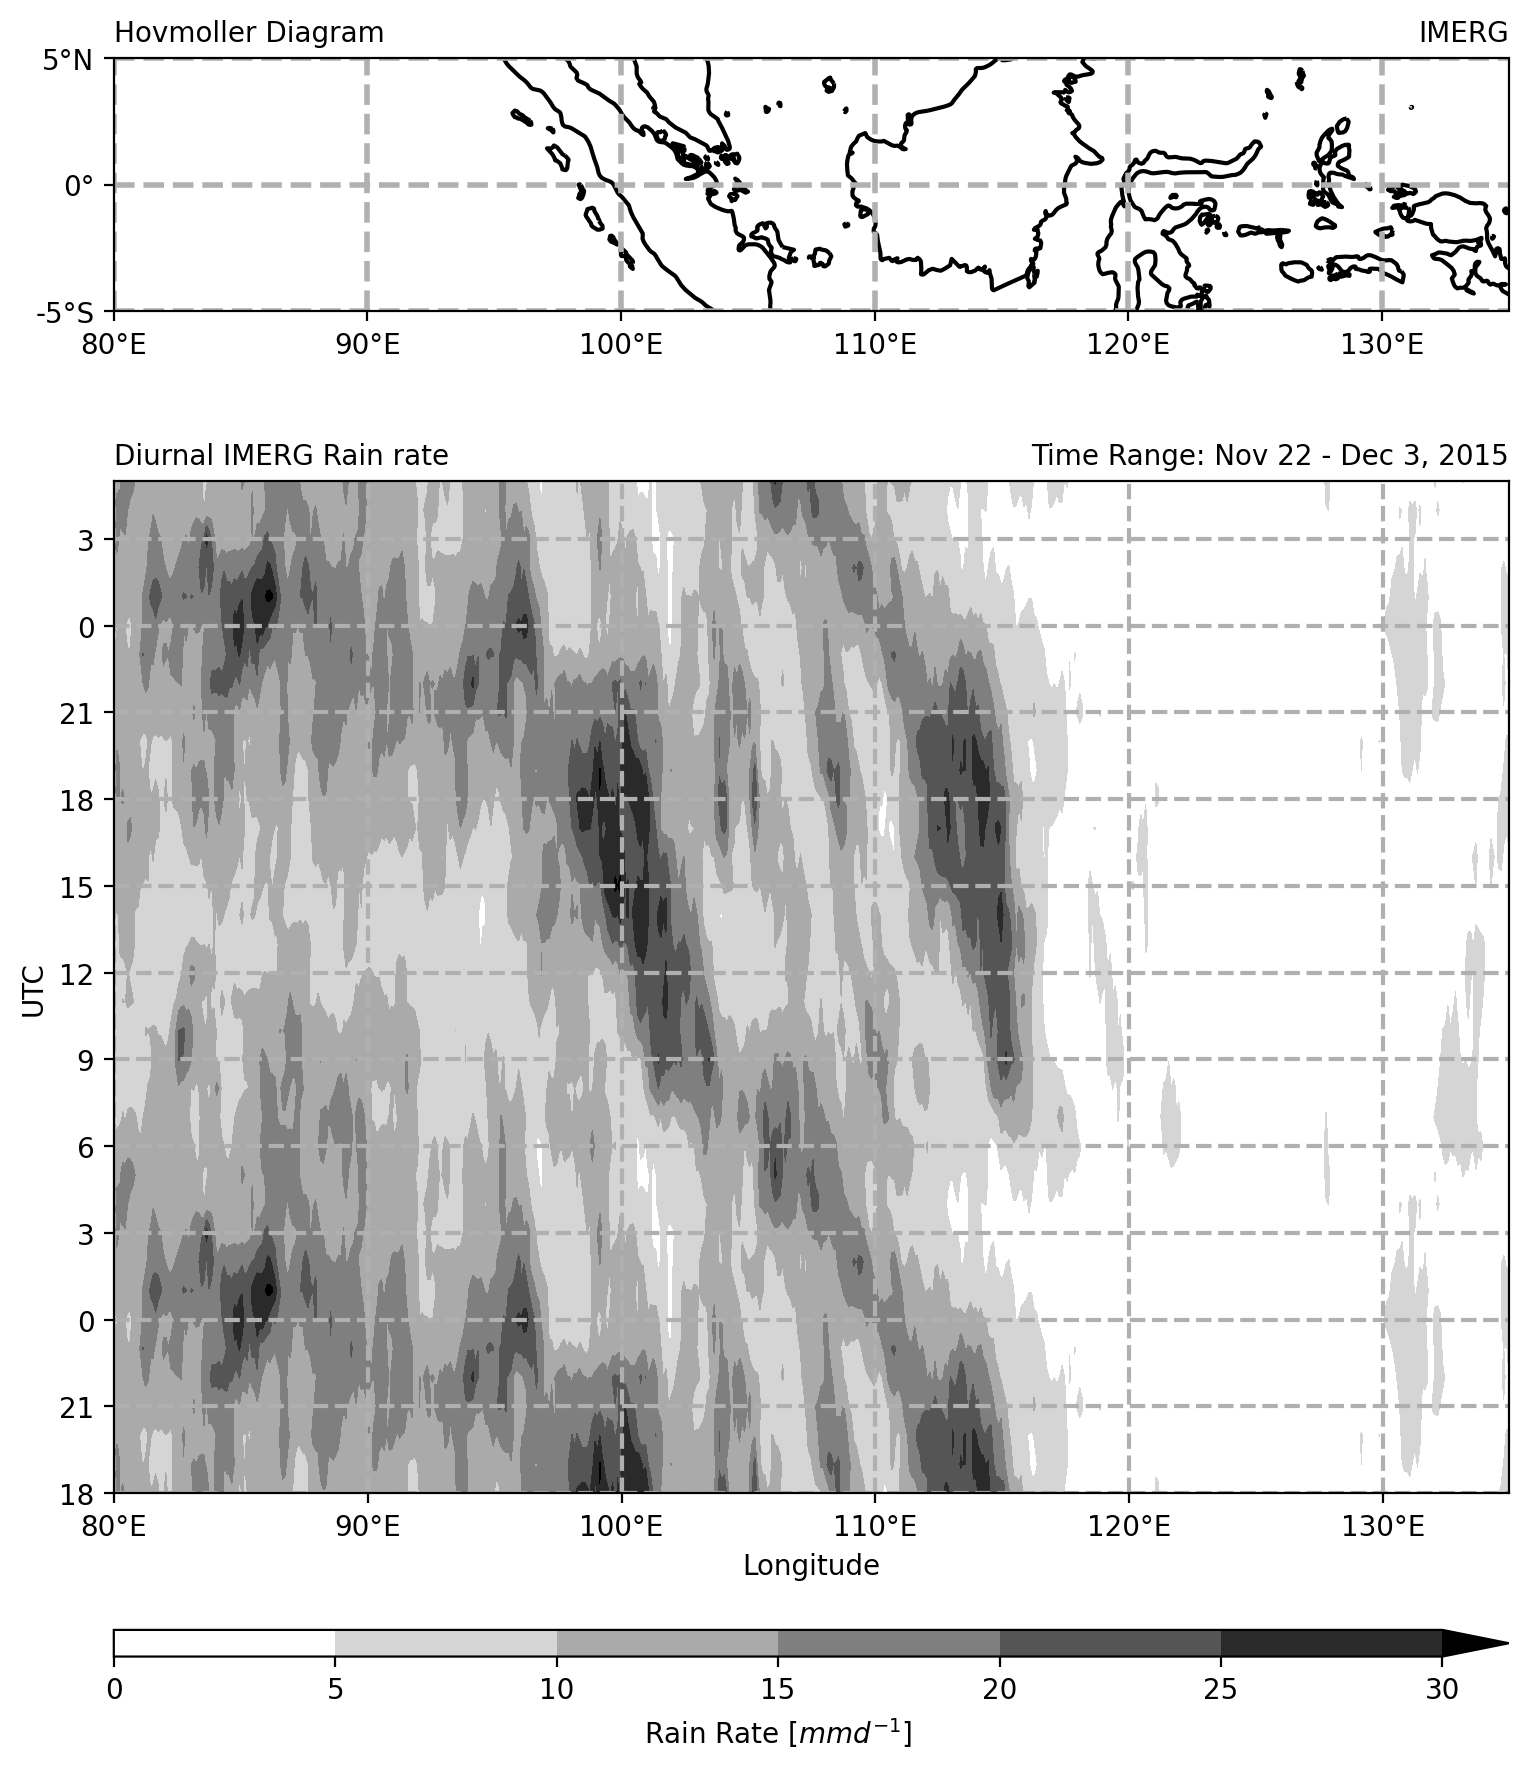

In [25]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.25,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1],10))
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E', u'130\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x1 = da_RR_IMERG.sel(
	lat=slice(-5,5), 
	time=slice('2015-11-22T12:00','2015-12-03T00:00')
).mean('lat')*24	# Make it rain rate per day instead of hour
x1 = x1.groupby('time.hour').mean()
x2 = xr.concat([x1.isel(hour=slice(18,24)),x1,x1.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x2.hour.values
x2 = x2.assign_coords(hour=(['hour'],np.arange(-6,30)))

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x2.plot.contourf(
    x = 'lon',
	y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1],10),
	cmap='gray_r',
	levels=np.arange(0,35,5),
	vmin=0, vmax=30,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Diurnal IMERG Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22 - Dec 3, 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(x2.hour[0::3].values)
ax2.set_yticklabels(yticks[0::3])
ax2.set_xlabel('Longitude')
ax2.set_ylabel('UTC')


Text(0, 0.5, 'UTC')

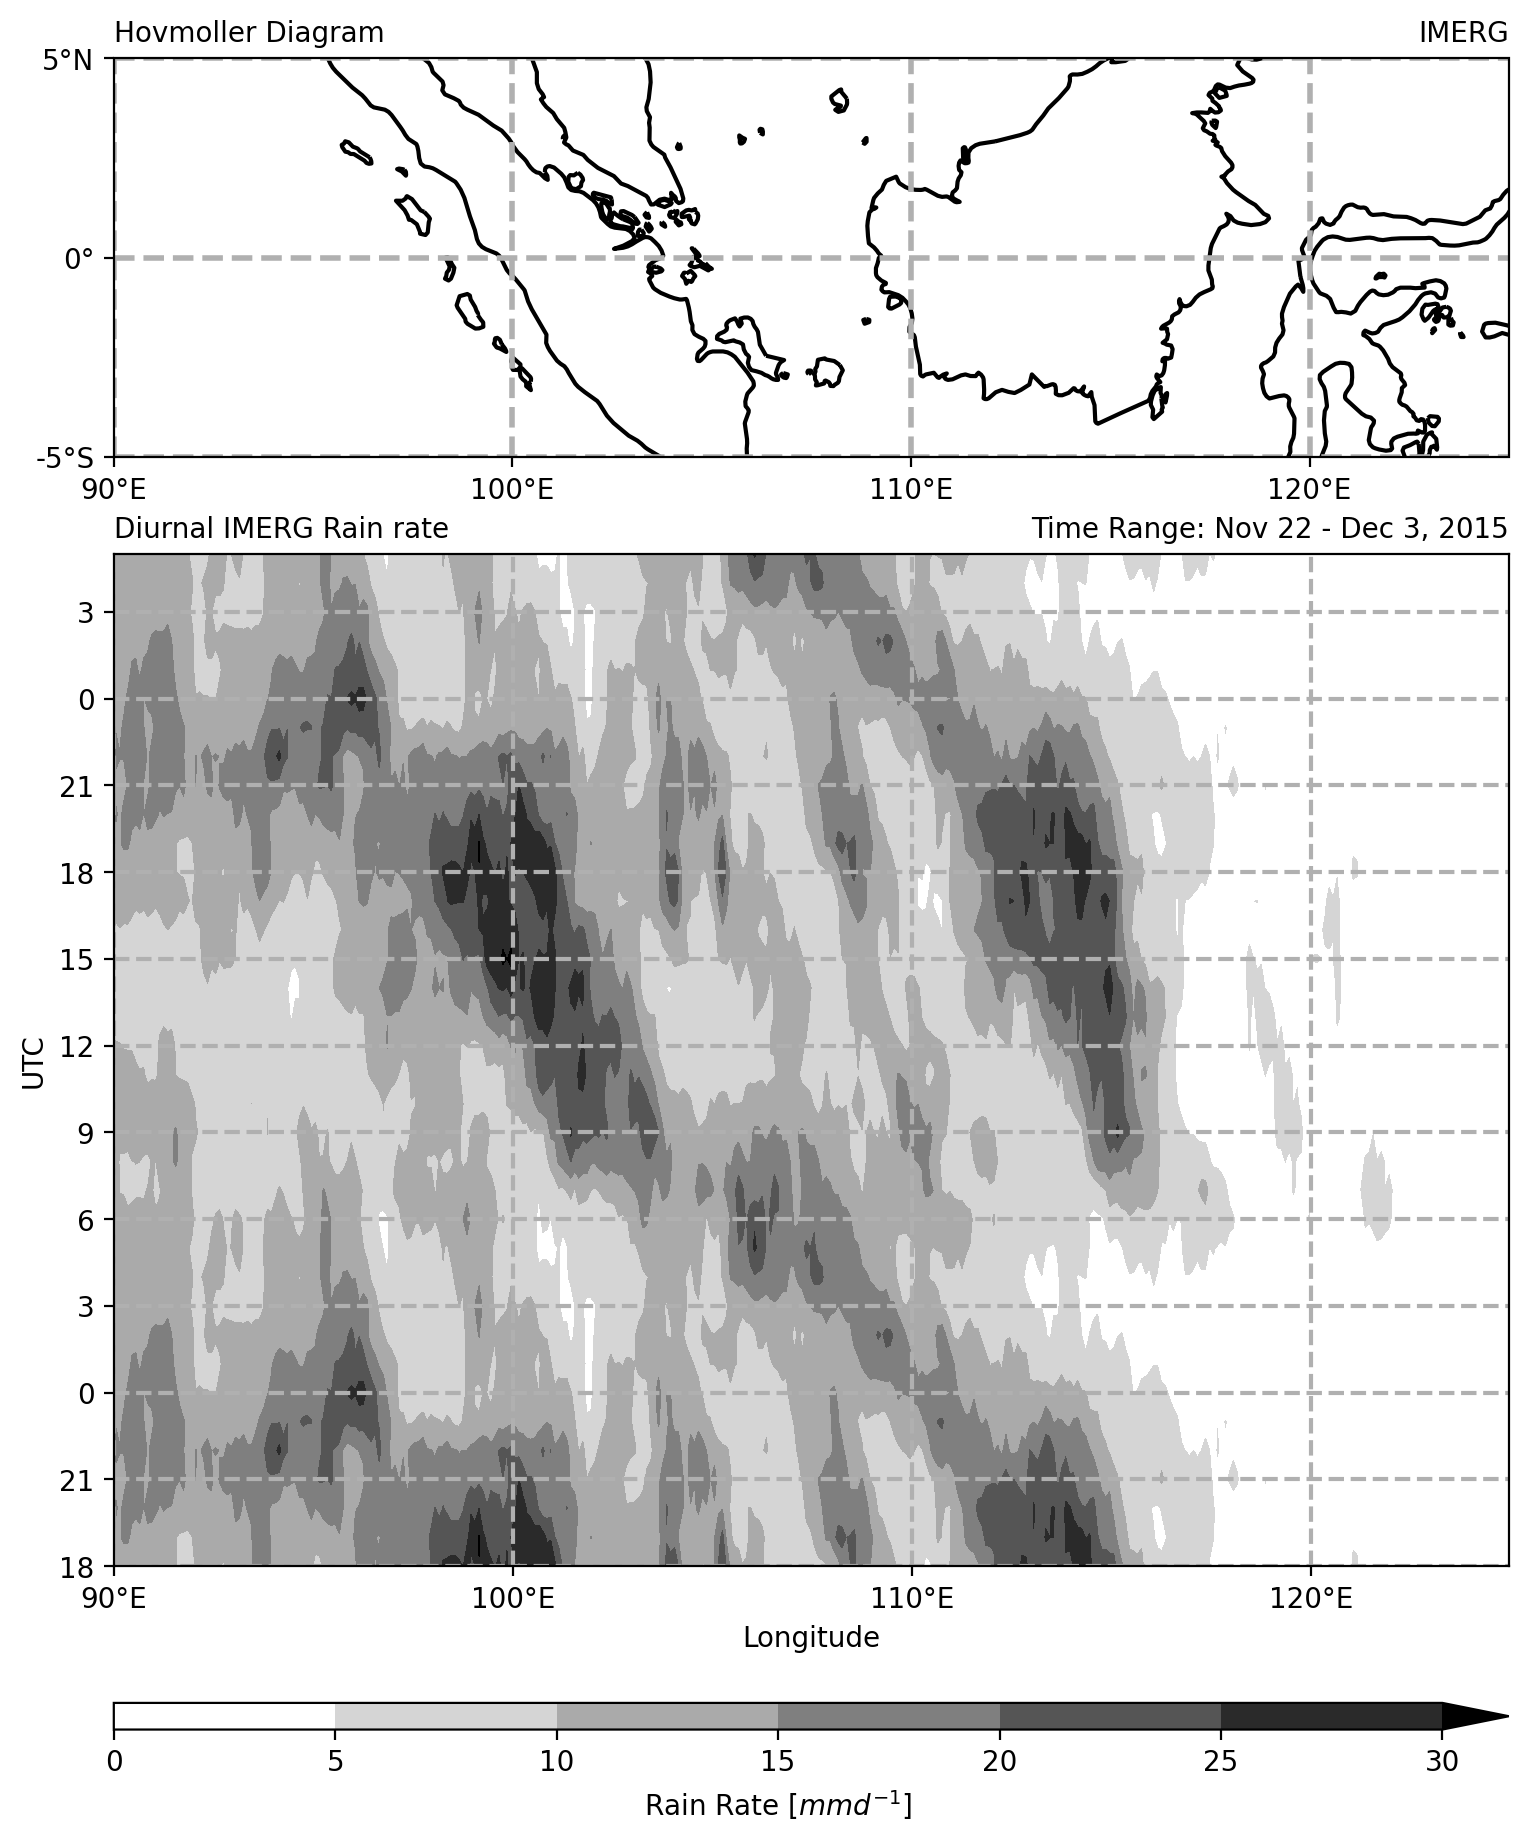

In [23]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.25,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound_d02[0],lon_bound_d02[1],10))
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]
# Read in the data:
	# Only look at between the latitude bounds: "lat_avg_bound"
x1 = da_RR_IMERG.sel(
	lat=slice(-5,5), 
	time=slice('2015-11-22T12:00','2015-12-03T00:00'),
	lon=slice(lon_bound_d02[0],lon_bound_d02[1])
).mean('lat')*24	# Make it rain rate per day instead of hour
x1 = x1.groupby('time.hour').mean()
x2 = xr.concat([x1.isel(hour=slice(18,24)),x1,x1.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x2.hour.values
x2 = x2.assign_coords(hour=(['hour'],np.arange(-6,30)))

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x2.plot.contourf(
    x = 'lon',
	y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound_d02[0],lon_bound_d02[1],10),
	cmap='gray_r',
	levels=np.arange(0,35,5),
	vmin=0, vmax=30,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Diurnal IMERG Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22 - Dec 3, 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(x2.hour[0::3].values)
ax2.set_yticklabels(yticks[0::3])
ax2.set_xlabel('Longitude')
ax2.set_ylabel('UTC')
